# Анализ данных VK Case Champ: Социальная коммерция

Цель: Провести комплексный анализ данных тестового запуска социальной коммерции для разработки стратегии развития

In [34]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Для нормализации метрик
try:
    from sklearn.preprocessing import MinMaxScaler
except ImportError:
    print("⚠ sklearn не установлен, будет использована альтернативная нормализация")

print("✓ Библиотеки импортированы успешно")

✓ Библиотеки импортированы успешно


## 1. Загрузка и предварительный анализ данных

In [35]:
# Загрузка данных
data_dir = Path('/content')

# Таблица №1 - Данные об оферах
df_offers = pd.read_csv(data_dir / 'df_offers.csv', sep=';')
print("Таблица №1 - Оферы:")
print(f"Размер: {df_offers.shape}")
print(f"Столбцы: {df_offers.columns.tolist()}")
print()

# Таблица №2 - Метрики размещений
df_stats = pd.read_csv(data_dir / 'df_stats.csv', sep=';')
print("Таблица №2 - Метрики:")
print(f"Размер: {df_stats.shape}")
print(f"Столбцы: {df_stats.columns.tolist()}")
print()

# Таблица №3 - Заказы
df_orders = pd.read_csv(data_dir / 'df_orders.csv', sep=';')
print("Таблица №3 - Заказы:")
print(f"Размер: {df_orders.shape}")
print(f"Столбцы: {df_orders.columns.tolist()}")
print()

# Таблица №4 - Размещения (тестовый запуск)
df_placements = pd.read_csv(data_dir / 'df_placements.csv', sep=';')
print("Таблица №4 - Размещения:")
print(f"Размер: {df_placements.shape}")
print(f"Столбцы: {df_placements.columns.tolist()}")
print()

print("✓ Все данные загружены успешно")

Таблица №1 - Оферы:
Размер: (28582, 7)
Столбцы: ['hash_offer_id', 'offer_created_at', 'placement_format', 'hash_seller_id', 'hash_model_id', 'category', 'price']

Таблица №2 - Метрики:
Размер: (87396, 3)
Столбцы: ['hash_placement_id', 'views', 'clicks']

Таблица №3 - Заказы:
Размер: (71825, 7)
Столбцы: ['hash_order_id', 'order_created_at', 'hash_placement_id', 'order_status_code', 'order_status_code_changed_at', 'GMV', 'reward_author']

Таблица №4 - Размещения:
Размер: (93479, 1)
Столбцы: ['hash_placement_id,placement_created_at,placement_format,hash_author_id,hash_offer_id,is_published,published_at']

✓ Все данные загружены успешно


In [36]:
# Исправление загрузки df_placements (если нужно)
if df_placements.shape[1] == 1:
    # Файл загрузился неправильно, пробуем с другим разделителем
    df_placements = pd.read_csv(data_dir / 'df_placements.csv', sep=',')
    print(f"✓ df_placements перезагружен: {df_placements.shape}")

# Преобразование дат
date_columns = {
    'df_offers': ['offer_created_at'],
    'df_orders': ['order_created_at', 'order_status_code_changed_at'],
    'df_placements': ['placement_created_at', 'published_at']
}

for col in date_columns['df_offers']:
    df_offers[col] = pd.to_datetime(df_offers[col], errors='coerce')

for col in date_columns['df_orders']:
    df_orders[col] = pd.to_datetime(df_orders[col], errors='coerce')

for col in date_columns['df_placements']:
    df_placements[col] = pd.to_datetime(df_placements[col], errors='coerce')

print("✓ Даты преобразованы в формат datetime")

✓ df_placements перезагружен: (93479, 7)
✓ Даты преобразованы в формат datetime


## 2. Блок 0: Предварительные вопросы и подготовка данных

In [37]:
# 2.1. Временные рамки тестового запуска
print("=" * 80)
print("ВОПРОС 1: Какой период охватывает тестовый запуск?")
print("=" * 80)

period_min = df_placements['published_at'].min()
period_max = df_placements['published_at'].max()
period_days = (period_max - period_min).days

print(f"\n📅 Период тестового запуска:")
print(f"   Начало: {period_min.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Окончание: {period_max.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Длительность: {period_days} дней")
print()

ВОПРОС 1: Какой период охватывает тестовый запуск?

📅 Период тестового запуска:
   Начало: 2025-07-14 19:00:00
   Окончание: 2025-08-26 00:00:00
   Длительность: 42 дней



In [38]:
# 2.2. Объем данных
print("=" * 80)
print("ВОПРОС 2: Объем данных тестового запуска")
print("=" * 80)

print(f"\n📊 Общая статистика:")
print(f"   Создано оферов: {df_offers['hash_offer_id'].nunique():,}")
print(f"   Создано размещений: {df_placements['hash_placement_id'].nunique():,}")
print(f"   Опубликовано размещений: {df_placements[df_placements['is_published'] == True]['hash_placement_id'].nunique():,}")
print()
print(f"   Уникальных продавцов: {df_offers['hash_seller_id'].nunique():,}")
print(f"   Уникальных авторов: {df_placements['hash_author_id'].nunique():,}")
print(f"   Уникальных товаров: {df_offers['hash_model_id'].nunique():,}")
print(f"   Товарных категорий: {df_offers['category'].nunique():,}")
print()

# Получим заказы, относящиеся к тестовому запуску
test_placement_ids = set(df_placements['hash_placement_id'].unique())
df_orders_test = df_orders[df_orders['hash_placement_id'].isin(test_placement_ids)].copy()

print(f"   Всего заказов (связанных с тестом): {len(df_orders_test):,}")
print(f"   Завершенных заказов: {len(df_orders_test[df_orders_test['order_status_code'] == 5]):,}")
print()

ВОПРОС 2: Объем данных тестового запуска

📊 Общая статистика:
   Создано оферов: 28,582
   Создано размещений: 93,479
   Опубликовано размещений: 87,390

   Уникальных продавцов: 28,582
   Уникальных авторов: 5,402
   Уникальных товаров: 28,582
   Товарных категорий: 15

   Всего заказов (связанных с тестом): 28,146
   Завершенных заказов: 0



In [39]:
# 2.3. Создание мастер-таблицы с объединением всех данных
print("=" * 80)
print("ВОПРОС 3: Связь таблиц - создание единого датасета")
print("=" * 80)

# Шаг 1: Объединяем размещения с оферами
master = df_placements.merge(
    df_offers,
    on='hash_offer_id',
    how='left',
    suffixes=('_placement', '_offer')
)
print(f"\n✓ Шаг 1: Размещения + Оферы = {master.shape[0]:,} строк")

# Шаг 2: Добавляем метрики (просмотры, клики)
master = master.merge(
    df_stats,
    on='hash_placement_id',
    how='left'
)
print(f"✓ Шаг 2: + Метрики = {master.shape[0]:,} строк")

# Шаг 3: Добавляем агрегированные данные по заказам
# Используем все заказы, так как статус 5 не встречается в данных
orders_agg = df_orders_test.groupby('hash_placement_id').agg({
    'hash_order_id': 'count',
    'GMV': 'sum',
    'reward_author': 'sum',
    'order_status_code': lambda x: (x != 3).sum()  # количество НЕ отмененных заказов
}).rename(columns={
    'hash_order_id': 'total_orders',
    'GMV': 'total_gmv',
    'reward_author': 'total_reward',
    'order_status_code': 'completed_orders'
}).reset_index()

master = master.merge(
    orders_agg,
    on='hash_placement_id',
    how='left'
)
print(f"✓ Шаг 3: + Заказы (агрегированные) = {master.shape[0]:,} строк")

# Заполняем пропуски нулями для числовых метрик
fill_cols = ['views', 'clicks', 'total_orders', 'total_gmv', 'total_reward', 'completed_orders']
for col in fill_cols:
    if col in master.columns:
        master[col] = master[col].fillna(0)

print(f"\n✓ Мастер-таблица создана: {master.shape[0]:,} строк, {master.shape[1]} столбцов")
print()

ВОПРОС 3: Связь таблиц - создание единого датасета

✓ Шаг 1: Размещения + Оферы = 93,479 строк
✓ Шаг 2: + Метрики = 93,479 строк
✓ Шаг 3: + Заказы (агрегированные) = 93,479 строк

✓ Мастер-таблица создана: 93,479 строк, 19 столбцов



In [40]:
# 2.4. Чистота данных - проверка пропусков и связей
print("=" * 80)
print("ВОПРОС 4: Чистота данных")
print("=" * 80)

print("\n📋 Проверка пропусков в основных таблицах:")
print(f"   df_offers: {df_offers.isnull().sum().sum()} пропусков")
print(f"   df_placements: {df_placements.isnull().sum().sum()} пропусков")
print(f"   df_stats: {df_stats.isnull().sum().sum()} пропусков")
print(f"   df_orders: {df_orders.isnull().sum().sum()} пропусков")
print()

# Проверяем связь между таблицами
placements_ids = set(df_placements['hash_placement_id'].unique())
stats_ids = set(df_stats['hash_placement_id'].unique())
orders_ids = set(df_orders_test['hash_placement_id'].unique())

missing_in_stats = placements_ids - stats_ids
missing_in_orders = placements_ids - orders_ids

print(f"📊 Связь между таблицами:")
print(f"   Размещений в Таблице №4: {len(placements_ids):,}")
print(f"   Размещений с метриками в Таблице №2: {len(stats_ids):,}")
print(f"   Размещений без метрик: {len(missing_in_stats):,} ({len(missing_in_stats)/len(placements_ids)*100:.1f}%)")
print()
print(f"   Размещений с заказами в Таблице №3: {len(orders_ids):,}")
print(f"   Размещений без заказов: {len(missing_in_orders):,} ({len(missing_in_orders)/len(placements_ids)*100:.1f}%)")
print()

print("💡 Интерпретация:")
print("   - Размещения без метрик - это нормально (возможно, еще не опубликованы)")
print("   - Размещения без заказов - тоже нормально (не все посты генерируют заказы)")
print()

ВОПРОС 4: Чистота данных

📋 Проверка пропусков в основных таблицах:
   df_offers: 0 пропусков
   df_placements: 7293 пропусков
   df_stats: 9 пропусков
   df_orders: 43682 пропусков

📊 Связь между таблицами:
   Размещений в Таблице №4: 93,479
   Размещений с метриками в Таблице №2: 87,388
   Размещений без метрик: 6,092 (6.5%)

   Размещений с заказами в Таблице №3: 8,252
   Размещений без заказов: 85,227 (91.2%)

💡 Интерпретация:
   - Размещения без метрик - это нормально (возможно, еще не опубликованы)
   - Размещения без заказов - тоже нормально (не все посты генерируют заказы)



## 3. Блок 1: Разработка стратегии наполнения каталога

ВОПРОС: Какие категории генерируют наибольший GMV?

📊 Топ-10 категорий по GMV:

                      total_gmv  completed_orders  placements_count  offers_count  avg_gmv_per_placement
category                                                                                                
Гардероб             46647537.0            4623.0             20708          7586            2252.633620
Дом и дача           38425067.0            9450.0             20100          5345            1911.694876
Красота и здоровье   20881752.0            6206.0              9564          3427            2183.370138
Спорт и отдых        17775948.0            1941.0             10565          3796            1682.531756
Бытовая техника      17230465.0            1074.0              6278           775            2744.578687
Электроника           6340324.0             474.0              3792           870            1672.026371
Детские товары        4152380.0             568.0              3371          121

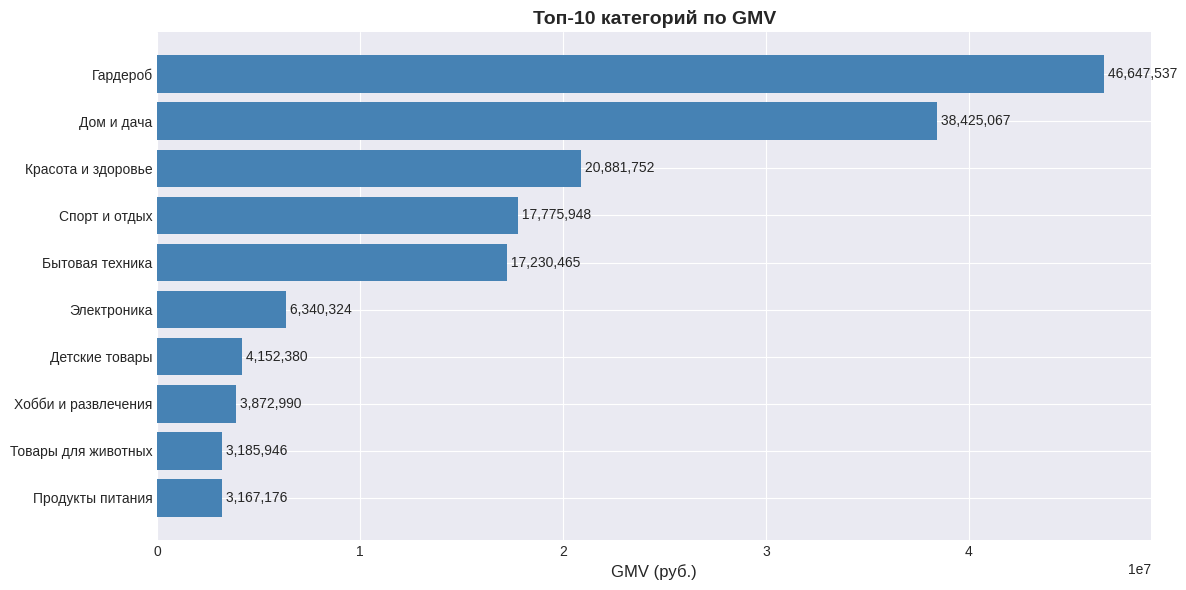

In [41]:
# 3.1. Анализ эффективности категорий по GMV
print("=" * 80)
print("ВОПРОС: Какие категории генерируют наибольший GMV?")
print("=" * 80)

# Фильтруем только опубликованные размещения
master_published = master[master['is_published'] == True].copy()

# Агрегация по категориям
category_gmv = master_published.groupby('category').agg({
    'total_gmv': 'sum',
    'completed_orders': 'sum',
    'hash_placement_id': 'count',
    'hash_offer_id': 'nunique'
}).rename(columns={
    'hash_placement_id': 'placements_count',
    'hash_offer_id': 'offers_count'
}).sort_values('total_gmv', ascending=False)

category_gmv['avg_gmv_per_placement'] = category_gmv['total_gmv'] / category_gmv['placements_count']

print(f"\n📊 Топ-10 категорий по GMV:\n")
print(category_gmv.head(10).to_string())
print()

# Визуализация
plt.figure(figsize=(12, 6))
top_10_gmv = category_gmv.head(10)
plt.barh(range(len(top_10_gmv)), top_10_gmv['total_gmv'], color='steelblue')
plt.yticks(range(len(top_10_gmv)), top_10_gmv.index)
plt.xlabel('GMV (руб.)', fontsize=12)
plt.title('Топ-10 категорий по GMV', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(top_10_gmv['total_gmv']):
    plt.text(v, i, f' {v:,.0f}', va='center')
plt.tight_layout()
plt.show()

ВОПРОС: Какие категории имеют самый высокий CR и CTR?

📊 Топ-10 категорий по CR (от кликов):

                          CTR  CR_clicks  CR_views     avg_check  placements
category                                                                    
Красота и здоровье   0.026195   6.423234  0.001683   3364.768289        9564
Товары для животных  0.022760   5.972618  0.001359   4901.455385        1160
Продукты питания     0.022023   5.817510  0.001281   3142.039683        2146
Дом и дача           0.027545   4.941564  0.001361   4066.144656       20100
Транспорт            0.016402   2.987580  0.000490   5331.901124        2513
Канцелярские товары  0.032029   2.809866  0.000900   6078.640000        2006
Гардероб             0.023095   2.727981  0.000630  10090.317326       20708
Бытовая техника      0.022432   2.154334  0.000483  16043.263501        6278
Товары для геймеров  0.024232   2.072539  0.000502   9974.333333          81
Хобби и развлечения  0.050142   2.052932  0.001029   4705.9

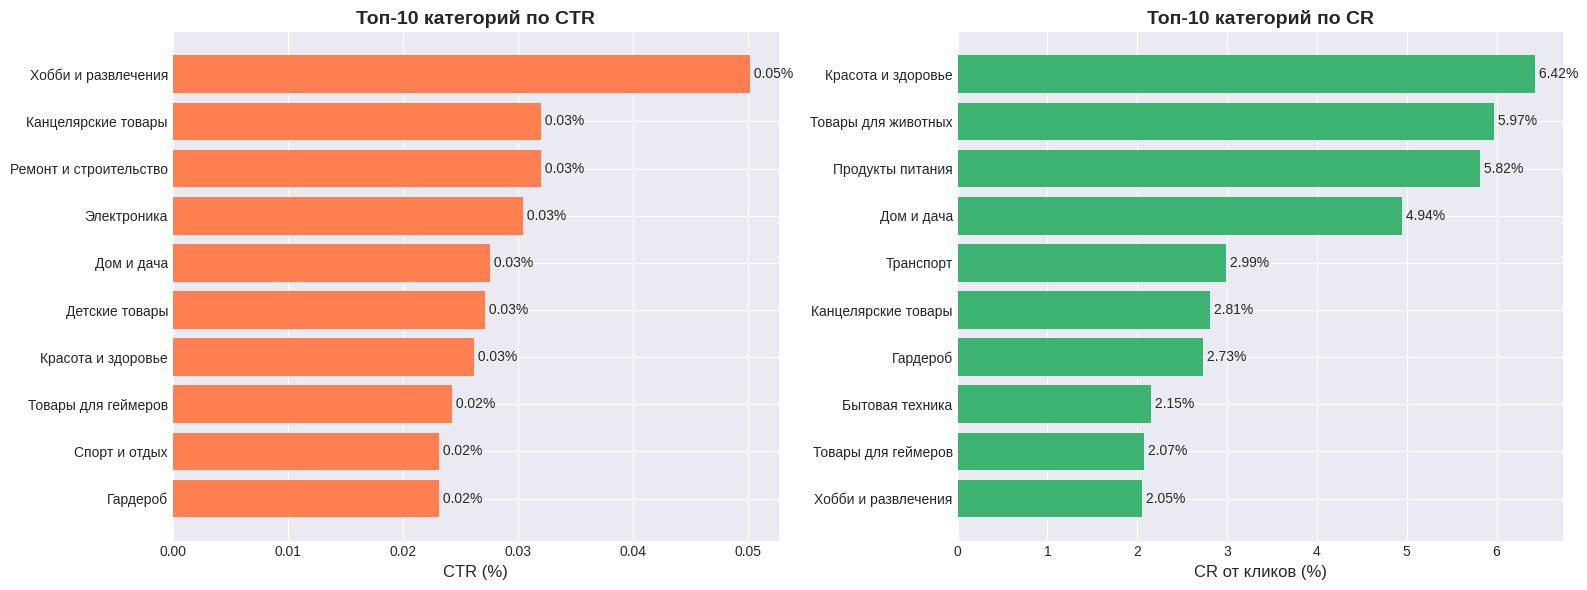

In [42]:
# 3.2. Анализ CR (Conversion Rate) и CTR по категориям
print("=" * 80)
print("ВОПРОС: Какие категории имеют самый высокий CR и CTR?")
print("=" * 80)

# Вычисляем метрики
category_metrics = master_published.groupby('category').agg({
    'views': 'sum',
    'clicks': 'sum',
    'completed_orders': 'sum',
    'total_gmv': 'sum',
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'placements'})

# CTR = клики / просмотры
category_metrics['CTR'] = (category_metrics['clicks'] / category_metrics['views'] * 100).fillna(0)

# CR = завершенные заказы / клики
category_metrics['CR_clicks'] = (category_metrics['completed_orders'] / category_metrics['clicks'] * 100).fillna(0)

# CR = завершенные заказы / просмотры
category_metrics['CR_views'] = (category_metrics['completed_orders'] / category_metrics['views'] * 100).fillna(0)

# Средний чек
category_metrics['avg_check'] = (category_metrics['total_gmv'] / category_metrics['completed_orders']).fillna(0)

# Сортируем по CR от кликов
category_metrics_sorted = category_metrics.sort_values('CR_clicks', ascending=False)

print(f"\n📊 Топ-10 категорий по CR (от кликов):\n")
print(category_metrics_sorted[['CTR', 'CR_clicks', 'CR_views', 'avg_check', 'placements']].head(10).to_string())
print()

print(f"\n📊 Топ-10 категорий по CTR:\n")
category_metrics_ctr = category_metrics.sort_values('CTR', ascending=False)
print(category_metrics_ctr[['CTR', 'CR_clicks', 'views', 'clicks', 'placements']].head(10).to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CTR
top_10_ctr = category_metrics_ctr.head(10)
axes[0].barh(range(len(top_10_ctr)), top_10_ctr['CTR'], color='coral')
axes[0].set_yticks(range(len(top_10_ctr)))
axes[0].set_yticklabels(top_10_ctr.index)
axes[0].set_xlabel('CTR (%)', fontsize=12)
axes[0].set_title('Топ-10 категорий по CTR', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(top_10_ctr['CTR']):
    axes[0].text(v, i, f' {v:.2f}%', va='center')

# CR
top_10_cr = category_metrics_sorted.head(10)
axes[1].barh(range(len(top_10_cr)), top_10_cr['CR_clicks'], color='mediumseagreen')
axes[1].set_yticks(range(len(top_10_cr)))
axes[1].set_yticklabels(top_10_cr.index)
axes[1].set_xlabel('CR от кликов (%)', fontsize=12)
axes[1].set_title('Топ-10 категорий по CR', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(top_10_cr['CR_clicks']):
    axes[1].text(v, i, f' {v:.2f}%', va='center')

plt.tight_layout()
plt.show()

ВОПРОС: Какие категории приносят наибольший средний чек и вознаграждение авторам?

📊 Топ-10 категорий по среднему чеку:

                           avg_check  avg_reward_per_order  reward_percent  completed_orders
category                                                                                    
Бытовая техника         16043.263501           4126.178771       25.719074            1074.0
Ремонт и строительство  14322.205674           3707.205674       25.884321             141.0
Электроника             13376.210970           3546.371308       26.512525             474.0
Гардероб                10090.317326           3051.510707       30.241970            4623.0
Товары для геймеров      9974.333333           2511.083333       25.175450              12.0
Спорт и отдых            9158.139104           2605.622360       28.451439            1941.0
Все товары               7766.428571           2915.142857       37.535179              14.0
Детские товары           7310.528169      

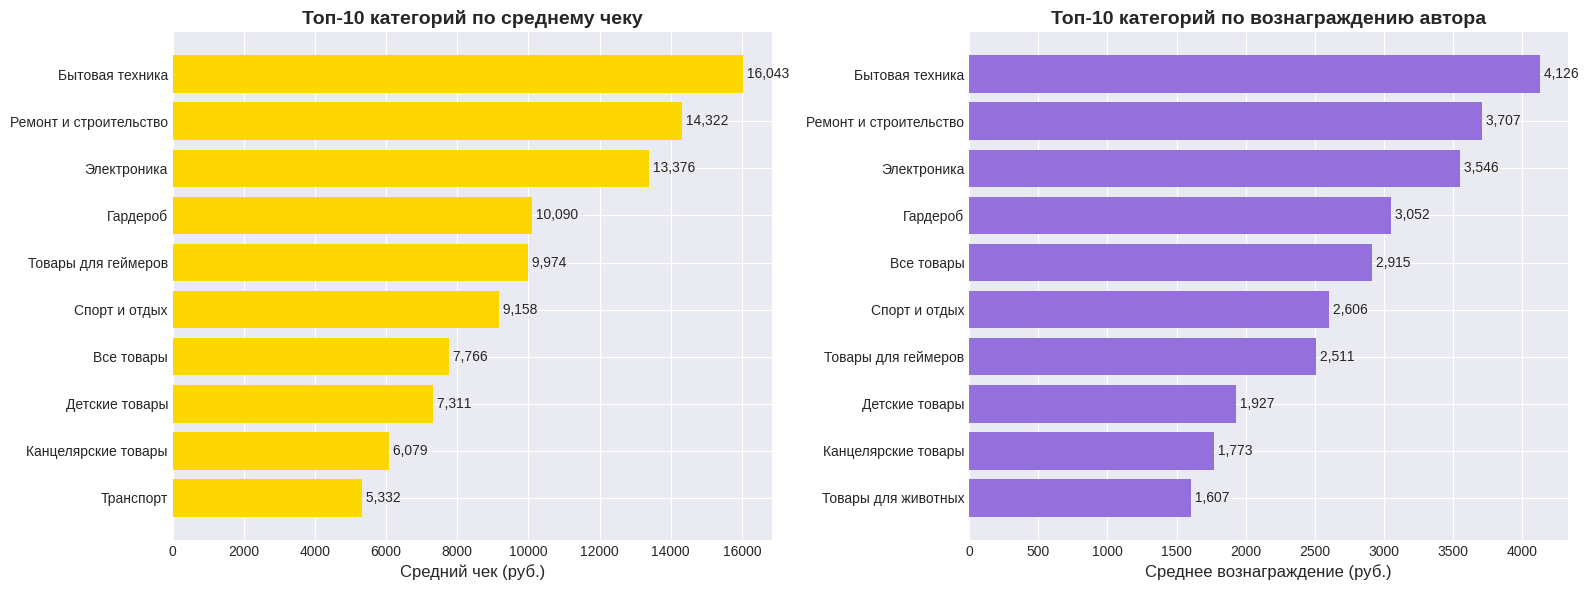

In [43]:
# 3.3. Анализ среднего чека и вознаграждения авторов по категориям
print("=" * 80)
print("ВОПРОС: Какие категории приносят наибольший средний чек и вознаграждение авторам?")
print("=" * 80)

category_revenue = master_published.groupby('category').agg({
    'total_gmv': 'sum',
    'total_reward': 'sum',
    'completed_orders': 'sum'
})

category_revenue['avg_check'] = (category_revenue['total_gmv'] / category_revenue['completed_orders']).fillna(0)
category_revenue['avg_reward_per_order'] = (category_revenue['total_reward'] / category_revenue['completed_orders']).fillna(0)
category_revenue['reward_percent'] = (category_revenue['total_reward'] / category_revenue['total_gmv'] * 100).fillna(0)

category_revenue_sorted = category_revenue.sort_values('avg_check', ascending=False)

print(f"\n📊 Топ-10 категорий по среднему чеку:\n")
print(category_revenue_sorted[['avg_check', 'avg_reward_per_order', 'reward_percent', 'completed_orders']].head(10).to_string())
print()

print(f"\n📊 Топ-10 категорий по среднему вознаграждению автора:\n")
category_reward_sorted = category_revenue.sort_values('avg_reward_per_order', ascending=False)
print(category_reward_sorted[['avg_reward_per_order', 'avg_check', 'reward_percent', 'completed_orders']].head(10).to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Средний чек
top_10_check = category_revenue_sorted.head(10)
axes[0].barh(range(len(top_10_check)), top_10_check['avg_check'], color='gold')
axes[0].set_yticks(range(len(top_10_check)))
axes[0].set_yticklabels(top_10_check.index)
axes[0].set_xlabel('Средний чек (руб.)', fontsize=12)
axes[0].set_title('Топ-10 категорий по среднему чеку', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(top_10_check['avg_check']):
    axes[0].text(v, i, f' {v:,.0f}', va='center')

# Среднее вознаграждение
top_10_reward = category_reward_sorted.head(10)
axes[1].barh(range(len(top_10_reward)), top_10_reward['avg_reward_per_order'], color='mediumpurple')
axes[1].set_yticks(range(len(top_10_reward)))
axes[1].set_yticklabels(top_10_reward.index)
axes[1].set_xlabel('Среднее вознаграждение (руб.)', fontsize=12)
axes[1].set_title('Топ-10 категорий по вознаграждению автора', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(top_10_reward['avg_reward_per_order']):
    axes[1].text(v, i, f' {v:,.0f}', va='center')

plt.tight_layout()
plt.show()

ВОПРОС: Как отличаются метрики для постов и клипов?

📊 Сравнение форматов:

                    views    clicks  completed_orders    total_gmv  placements       CTR        CR  avg_gmv_per_placement
format_name                                                                                                              
Клип         2.554032e+09  378623.0           18284.0  112331762.0       75017  0.014825  4.829078            1497.417412
Пост         5.828209e+08  427959.0            9862.0   58969613.0       12373  0.073429  2.304426            4765.991514


📊 Топ-10 категорий где КЛИПЫ работают лучше (по CTR):

format_name                 Клип      Пост  clip_advantage
category                                                  
Все товары              0.011613  0.042882       -0.031269
Ремонт и строительство  0.022655  0.059540       -0.036885
Спорт и отдых           0.012933  0.058597       -0.045664
Гардероб                0.011055  0.062802       -0.051747
Продукты питания        0

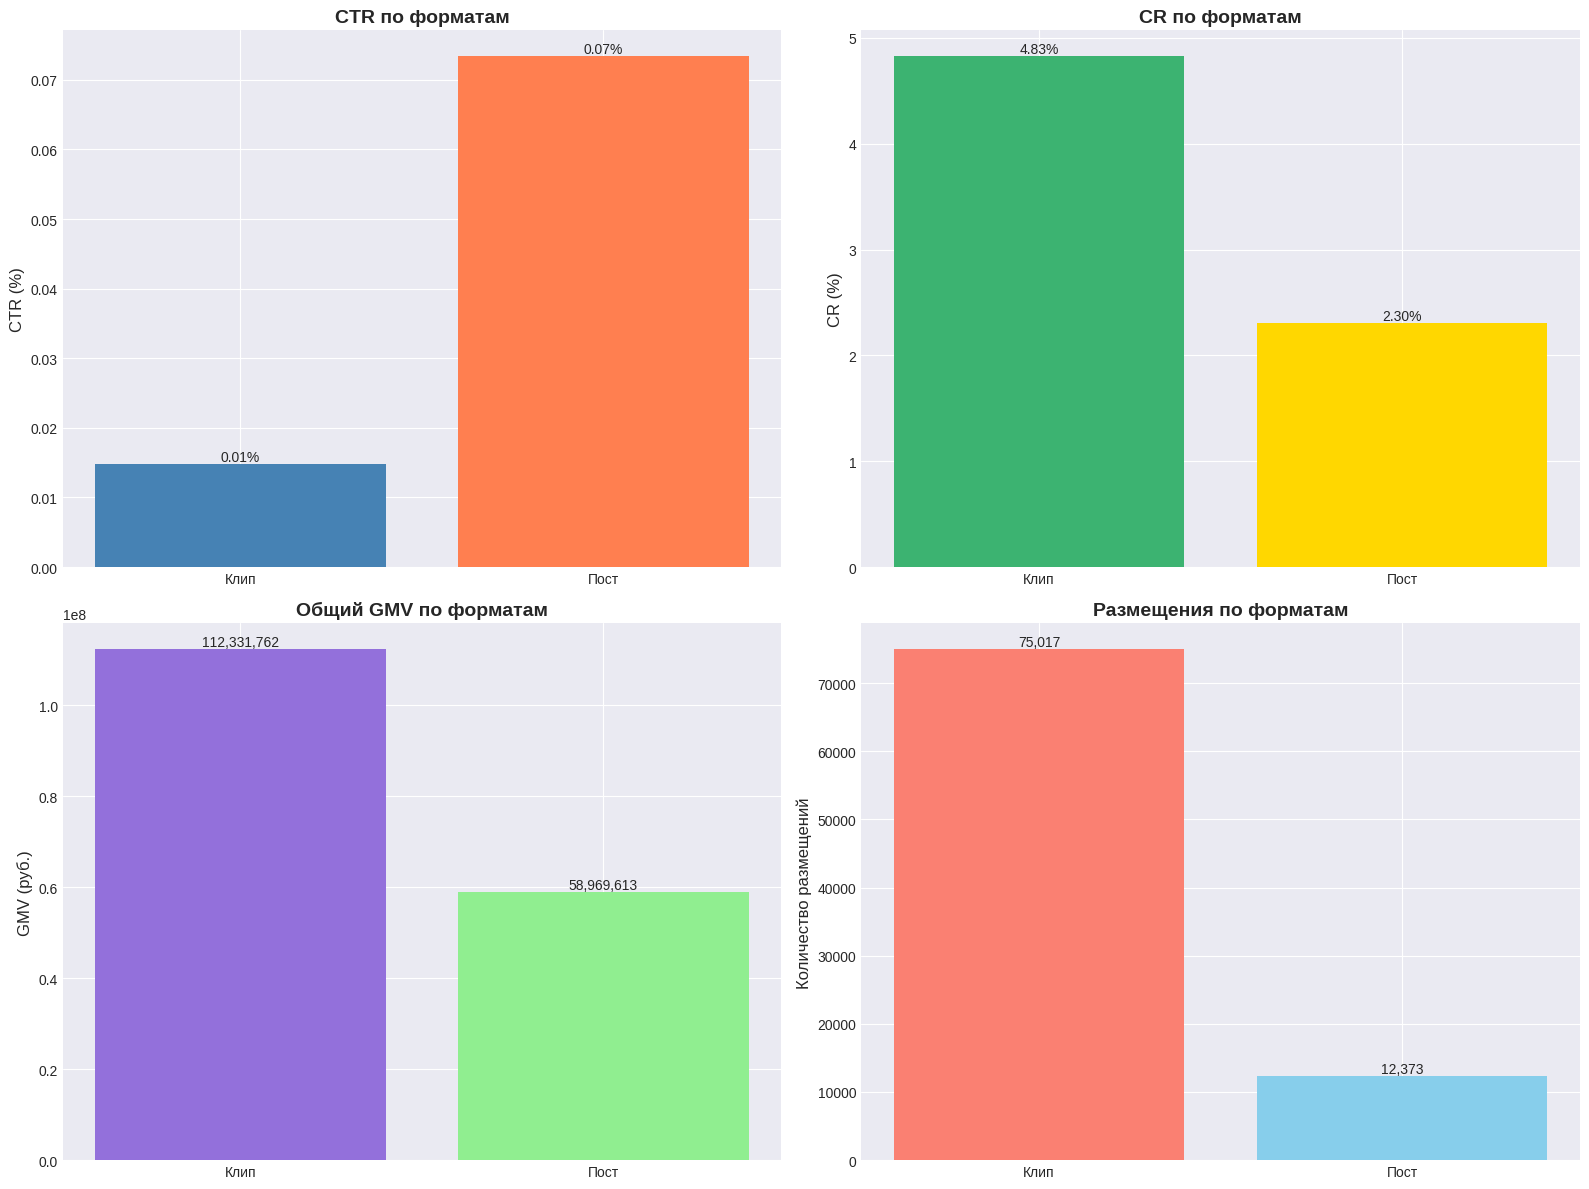

In [66]:
# 3.4. Анализ влияния формата контента (посты vs клипы)
print("=" * 80)
print("ВОПРОС: Как отличаются метрики для постов и клипов?")
print("=" * 80)

# Создаем словарь для формата
format_names = {'post': 'Пост', 'clip': 'Клип'}
# Используем правильное имя колонки (с суффиксом)
format_col = 'placement_format' if 'placement_format' in master_published.columns else 'placement_format_placement'
master_published['format_name'] = master_published[format_col].map(format_names)

# Общая статистика по форматам
format_stats = master_published.groupby('format_name').agg({
    'views': 'sum',
    'clicks': 'sum',
    'completed_orders': 'sum',
    'total_gmv': 'sum',
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'placements'})

format_stats['CTR'] = (format_stats['clicks'] / format_stats['views'] * 100).fillna(0)
format_stats['CR'] = (format_stats['completed_orders'] / format_stats['clicks'] * 100).fillna(0)
format_stats['avg_gmv_per_placement'] = format_stats['total_gmv'] / format_stats['placements']

print(f"\n📊 Сравнение форматов:\n")
print(format_stats.to_string())
print()

# Анализ по категориям и форматам
format_category = master_published.groupby(['category', 'format_name']).agg({
    'views': 'sum',
    'clicks': 'sum',
    'completed_orders': 'sum',
    'total_gmv': 'sum',
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'placements'})

format_category['CTR'] = (format_category['clicks'] / format_category['views'] * 100).fillna(0)
format_category['CR'] = (format_category['completed_orders'] / format_category['clicks'] * 100).fillna(0)

# Находим категории, где клипы работают лучше постов
format_pivot_ctr = format_category['CTR'].unstack(fill_value=0)
format_pivot_gmv = format_category['total_gmv'].unstack(fill_value=0)

if 'Клип' in format_pivot_ctr.columns and 'Пост' in format_pivot_ctr.columns:
    format_pivot_ctr['clip_advantage'] = format_pivot_ctr['Клип'] - format_pivot_ctr['Пост']
    format_pivot_gmv['clip_advantage'] = format_pivot_gmv['Клип'] - format_pivot_gmv['Пост']

    print(f"\n📊 Топ-10 категорий где КЛИПЫ работают лучше (по CTR):\n")
    clip_winners = format_pivot_ctr.sort_values('clip_advantage', ascending=False).head(10)
    print(clip_winners[['Клип', 'Пост', 'clip_advantage']].to_string())
    print()

    print(f"\n📊 Топ-10 категорий где ПОСТЫ работают лучше (по CTR):\n")
    post_winners = format_pivot_ctr.sort_values('clip_advantage', ascending=True).head(10)
    print(post_winners[['Клип', 'Пост', 'clip_advantage']].to_string())
    print()

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# CTR по форматам
axes[0, 0].bar(format_stats.index, format_stats['CTR'], color=['steelblue', 'coral'])
axes[0, 0].set_ylabel('CTR (%)', fontsize=12)
axes[0, 0].set_title('CTR по форматам', fontsize=14, fontweight='bold')
for i, v in enumerate(format_stats['CTR']):
    axes[0, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# CR по форматам
axes[0, 1].bar(format_stats.index, format_stats['CR'], color=['mediumseagreen', 'gold'])
axes[0, 1].set_ylabel('CR (%)', fontsize=12)
axes[0, 1].set_title('CR по форматам', fontsize=14, fontweight='bold')
for i, v in enumerate(format_stats['CR']):
    axes[0, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# GMV по форматам
axes[1, 0].bar(format_stats.index, format_stats['total_gmv'], color=['mediumpurple', 'lightgreen'])
axes[1, 0].set_ylabel('GMV (руб.)', fontsize=12)
axes[1, 0].set_title('Общий GMV по форматам', fontsize=14, fontweight='bold')
for i, v in enumerate(format_stats['total_gmv']):
    axes[1, 0].text(i, v, f'{v:,.0f}', ha='center', va='bottom')

# Количество размещений по форматам
axes[1, 1].bar(format_stats.index, format_stats['placements'], color=['salmon', 'skyblue'])
axes[1, 1].set_ylabel('Количество размещений', fontsize=12)
axes[1, 1].set_title('Размещения по форматам', fontsize=14, fontweight='bold')
for i, v in enumerate(format_stats['placements']):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

ВОПРОС: Как цена товара влияет на конверсию и GMV?

📊 Анализ по ценовым сегментам:

                     views    clicks  completed_orders   total_gmv  placements      avg_price       CTR         CR  avg_gmv_per_placement
price_segment                                                                                                                            
<500             3383246.0     854.0              87.0     70481.0          70     447.728571  0.025242  10.187354            1006.871429
500-1000        35347552.0    8526.0             805.0    924866.0        1304     821.398006  0.024120   9.441708             709.253067
1000-2000      351203031.0   76570.0            7632.0  15296056.0        8868    1586.292287  0.021802   9.967350            1724.859720
2000-5000      699971865.0  196895.0           10511.0  39926946.0       19362    3248.586510  0.028129   5.338378            2062.129222
5000-10000     841484837.0  195998.0            5316.0  45454052.0       24551    7050.0

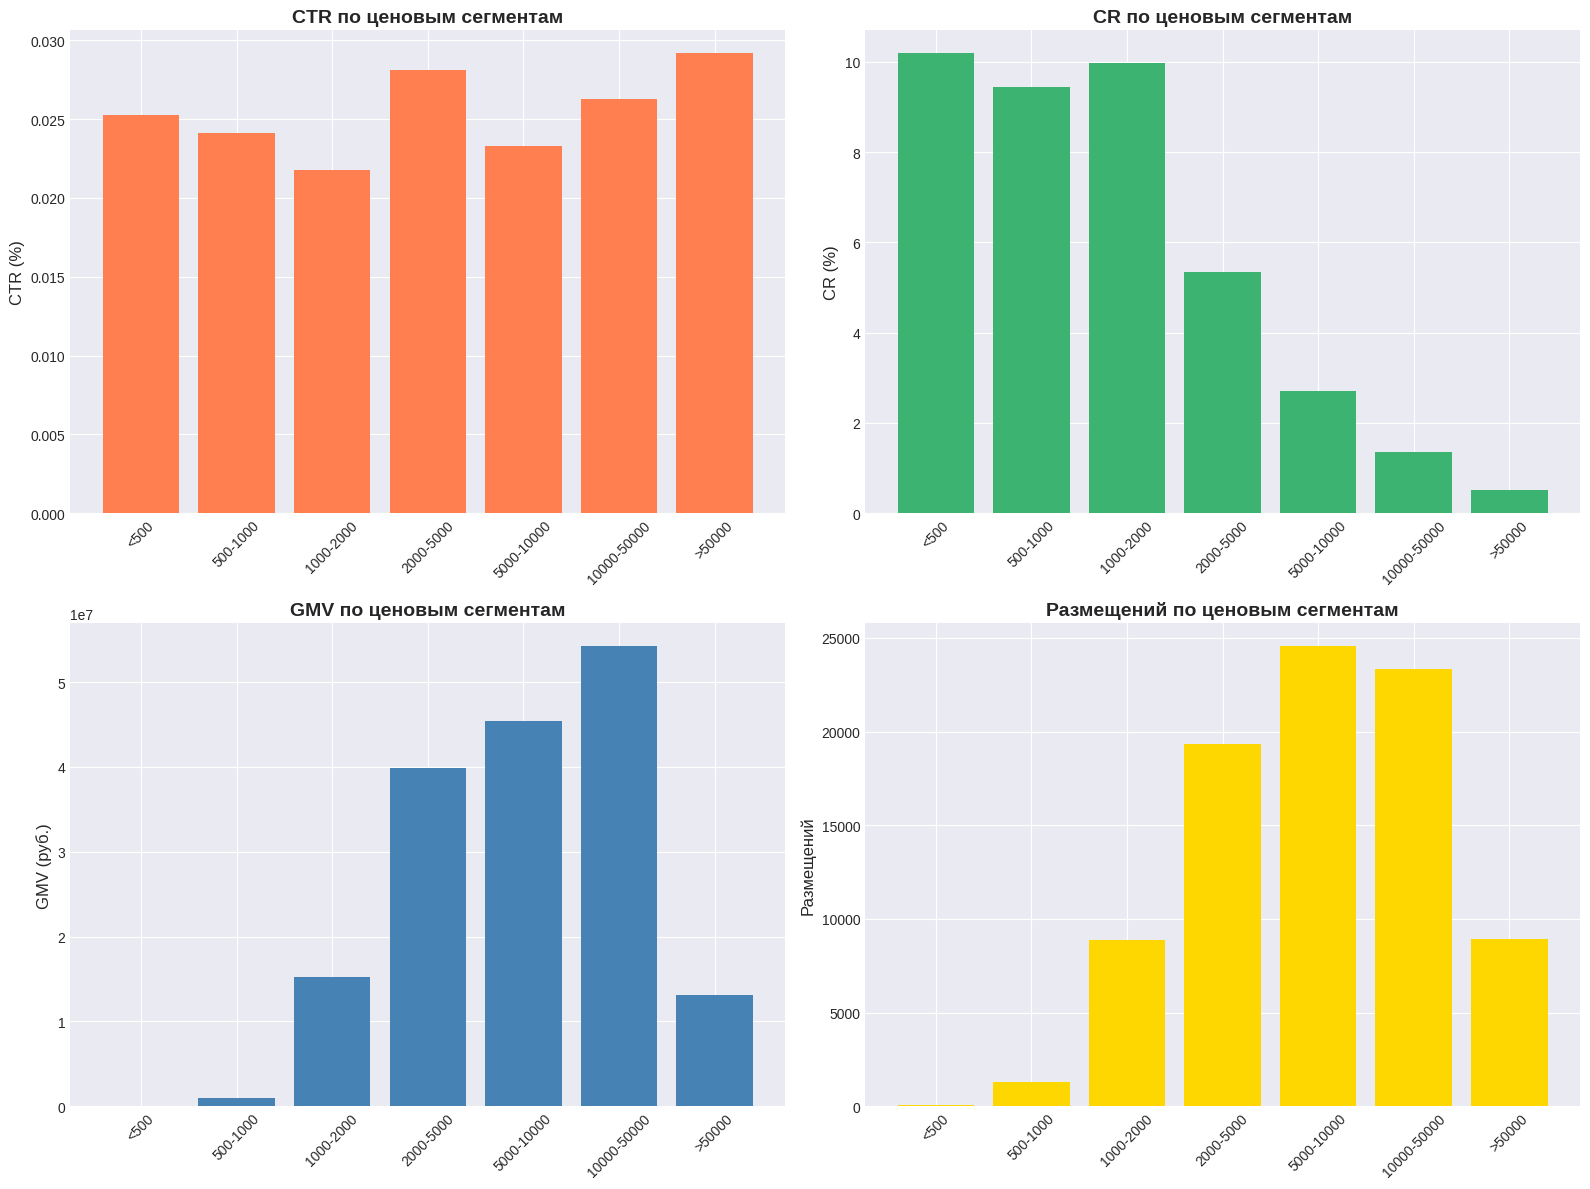

In [45]:
# 3.5. Анализ влияния цены товара
print("=" * 80)
print("ВОПРОС: Как цена товара влияет на конверсию и GMV?")
print("=" * 80)

# Создаем ценовые сегменты
master_published['price_segment'] = pd.cut(
    master_published['price'],
    bins=[0, 500, 1000, 2000, 5000, 10000, 50000, float('inf')],
    labels=['<500', '500-1000', '1000-2000', '2000-5000', '5000-10000', '10000-50000', '>50000']
)

price_analysis = master_published.groupby('price_segment').agg({
    'views': 'sum',
    'clicks': 'sum',
    'completed_orders': 'sum',
    'total_gmv': 'sum',
    'hash_placement_id': 'count',
    'price': 'mean'
}).rename(columns={'hash_placement_id': 'placements', 'price': 'avg_price'})

price_analysis['CTR'] = (price_analysis['clicks'] / price_analysis['views'] * 100).fillna(0)
price_analysis['CR'] = (price_analysis['completed_orders'] / price_analysis['clicks'] * 100).fillna(0)
price_analysis['avg_gmv_per_placement'] = price_analysis['total_gmv'] / price_analysis['placements']

print(f"\n📊 Анализ по ценовым сегментам:\n")
print(price_analysis.to_string())
print()

print(f"\n💡 Оптимальный ценовой диапазон для импульсивных покупок:")
best_price_segment = price_analysis.sort_values('CR', ascending=False).head(3)
print(f"   Топ-3 сегмента по CR:")
for idx, row in best_price_segment.iterrows():
    print(f"   {idx}: CR={row['CR']:.2f}%, CTR={row['CTR']:.2f}%, средняя цена={row['avg_price']:,.0f}₽")
print()

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# CTR по цене
axes[0, 0].bar(range(len(price_analysis)), price_analysis['CTR'], color='coral')
axes[0, 0].set_xticks(range(len(price_analysis)))
axes[0, 0].set_xticklabels(price_analysis.index, rotation=45)
axes[0, 0].set_ylabel('CTR (%)', fontsize=12)
axes[0, 0].set_title('CTR по ценовым сегментам', fontsize=14, fontweight='bold')

# CR по цене
axes[0, 1].bar(range(len(price_analysis)), price_analysis['CR'], color='mediumseagreen')
axes[0, 1].set_xticks(range(len(price_analysis)))
axes[0, 1].set_xticklabels(price_analysis.index, rotation=45)
axes[0, 1].set_ylabel('CR (%)', fontsize=12)
axes[0, 1].set_title('CR по ценовым сегментам', fontsize=14, fontweight='bold')

# GMV по цене
axes[1, 0].bar(range(len(price_analysis)), price_analysis['total_gmv'], color='steelblue')
axes[1, 0].set_xticks(range(len(price_analysis)))
axes[1, 0].set_xticklabels(price_analysis.index, rotation=45)
axes[1, 0].set_ylabel('GMV (руб.)', fontsize=12)
axes[1, 0].set_title('GMV по ценовым сегментам', fontsize=14, fontweight='bold')

# Количество размещений по цене
axes[1, 1].bar(range(len(price_analysis)), price_analysis['placements'], color='gold')
axes[1, 1].set_xticks(range(len(price_analysis)))
axes[1, 1].set_xticklabels(price_analysis.index, rotation=45)
axes[1, 1].set_ylabel('Размещений', fontsize=12)
axes[1, 1].set_title('Размещений по ценовым сегментам', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [46]:
# 3.6. Товары-хиты в каждой категории
print("=" * 80)
print("ВОПРОС: Какие товары показывают аномально высокие результаты?")
print("=" * 80)

# Анализ по товарам
product_performance = master_published.groupby(['hash_model_id', 'category', 'price']).agg({
    'total_gmv': 'sum',
    'completed_orders': 'sum',
    'views': 'sum',
    'clicks': 'sum',
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'placements'}).reset_index()

product_performance['CR'] = (product_performance['completed_orders'] / product_performance['clicks'] * 100).fillna(0)
product_performance['CTR'] = (product_performance['clicks'] / product_performance['views'] * 100).fillna(0)

# Топ товаров по GMV
print(f"\n📊 Топ-10 товаров-хитов по GMV:\n")
top_products_gmv = product_performance.sort_values('total_gmv', ascending=False).head(10)
print(top_products_gmv[['category', 'price', 'total_gmv', 'completed_orders', 'CR', 'CTR', 'placements']].to_string())
print()

# Для каждой категории найдем лучший товар
print(f"\n📊 Лучший товар в каждой категории (по GMV):\n")
best_per_category = product_performance.loc[product_performance.groupby('category')['total_gmv'].idxmax()]
print(best_per_category[['category', 'price', 'total_gmv', 'completed_orders', 'CR', 'placements']].sort_values('total_gmv', ascending=False).head(15).to_string())
print()

ВОПРОС: Какие товары показывают аномально высокие результаты?

📊 Топ-10 товаров-хитов по GMV:

                 category      price  total_gmv  completed_orders           CR       CTR  placements
24912          Дом и дача     2406.0  3964033.0            1069.0  3239.393939  0.009977           1
10267            Гардероб     8945.0  1637490.0             199.0    10.803474  0.190563          23
13798          Дом и дача    10512.0  1630659.0             158.0     2.487014  0.066732          60
23855     Бытовая техника  2804972.0  1314915.0              86.0     1.520240  0.072868          34
11818         Электроника    19591.0  1146520.0              44.0     1.412520  0.140275           3
9045      Бытовая техника   838734.0  1097718.0               1.0     1.250000  0.009154          33
10391            Гардероб     9862.0  1071552.0             105.0     3.211991  0.254561           3
20700     Бытовая техника    86935.0  1029918.0              12.0     2.061856  0.024416         

ВОПРОС: Какие категории авторы выбирают чаще всего?

📊 Топ-15 категорий по популярности у авторов:

                        placements  unique_authors  unique_offers  placements_per_offer
category                                                                               
Гардероб                     21898            3535           7895              2.773654
Дом и дача                   21210            3755           5560              3.814748
Спорт и отдых                11283            2966           3986              2.830657
Красота и здоровье           10334            2661           3626              2.849972
Бытовая техника               6615            2421            801              8.258427
Электроника                   4010            1860            896              4.475446
Детские товары                3692            1749           1266              2.916272
Хобби и развлечения           3185            1250           1416              2.249294
Транспорт           

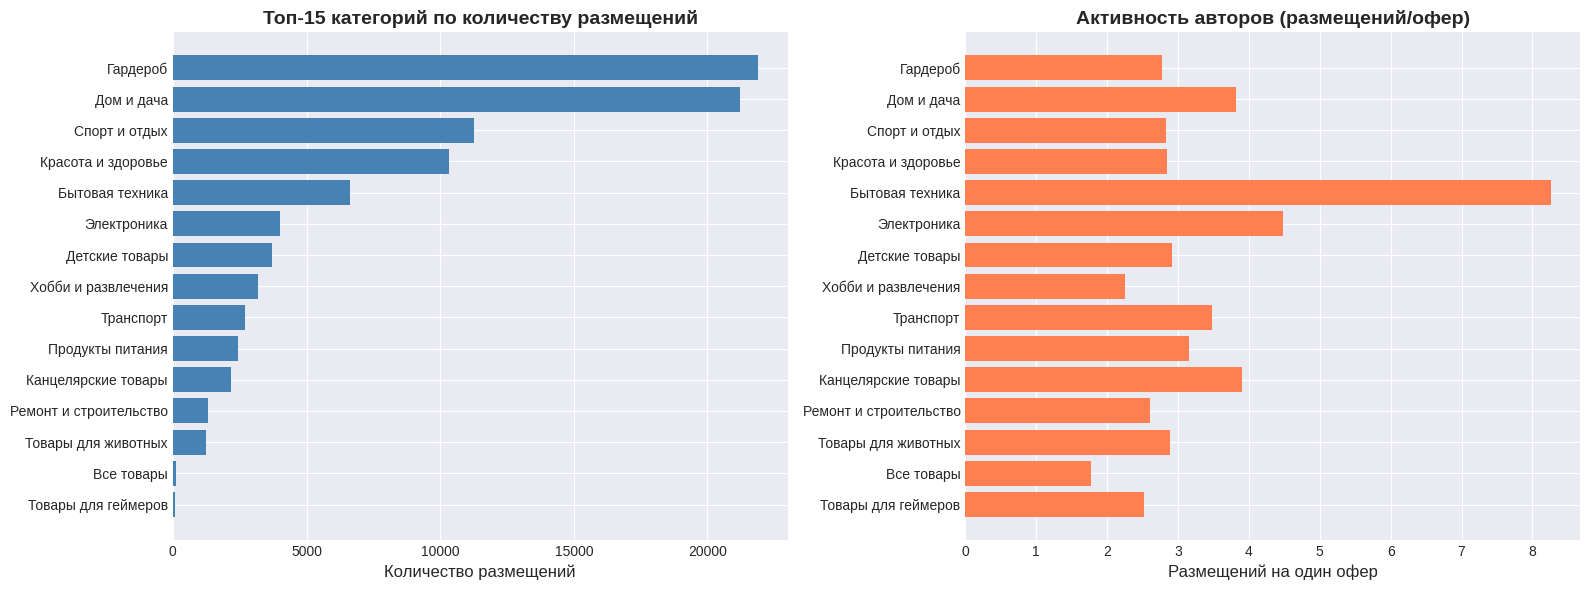

In [47]:
# 3.7. Популярность категорий у авторов
print("=" * 80)
print("ВОПРОС: Какие категории авторы выбирают чаще всего?")
print("=" * 80)

# Количество размещений по категориям
category_popularity = master.groupby('category').agg({
    'hash_placement_id': 'count',
    'hash_author_id': 'nunique',
    'hash_offer_id': 'nunique'
}).rename(columns={
    'hash_placement_id': 'placements',
    'hash_author_id': 'unique_authors',
    'hash_offer_id': 'unique_offers'
}).sort_values('placements', ascending=False)

category_popularity['placements_per_offer'] = category_popularity['placements'] / category_popularity['unique_offers']

print(f"\n📊 Топ-15 категорий по популярности у авторов:\n")
print(category_popularity.head(15).to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_15_pop = category_popularity.head(15)

# Количество размещений
axes[0].barh(range(len(top_15_pop)), top_15_pop['placements'], color='steelblue')
axes[0].set_yticks(range(len(top_15_pop)))
axes[0].set_yticklabels(top_15_pop.index)
axes[0].set_xlabel('Количество размещений', fontsize=12)
axes[0].set_title('Топ-15 категорий по количеству размещений', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Размещений на один офер
axes[1].barh(range(len(top_15_pop)), top_15_pop['placements_per_offer'], color='coral')
axes[1].set_yticks(range(len(top_15_pop)))
axes[1].set_yticklabels(top_15_pop.index)
axes[1].set_xlabel('Размещений на один офер', fontsize=12)
axes[1].set_title('Активность авторов (размещений/офер)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

ВОПРОС: Как быстро авторы берут в работу оферы из разных категорий?

📊 Топ-15 категорий с самым быстрым откликом авторов:

                        avg_hours  median_hours  min_hours  max_hours  placements
category                                                                         
Все товары                  57.77          14.0        1.0      488.0         129
Товары для геймеров         50.04          16.0        0.0      426.0          93
Ремонт и строительство      74.56          25.0        0.0      679.0        1304
Продукты питания            70.96          27.0        0.0      651.0        2429
Канцелярские товары         79.71          28.0        0.0      680.0        2159
Гардероб                    91.86          35.0        0.0      710.0       21898
Красота и здоровье         110.18          43.0        0.0      718.0       10334
Детские товары              95.49          43.0        0.0      716.0        3692
Спорт и отдых              107.01          45.0        0.

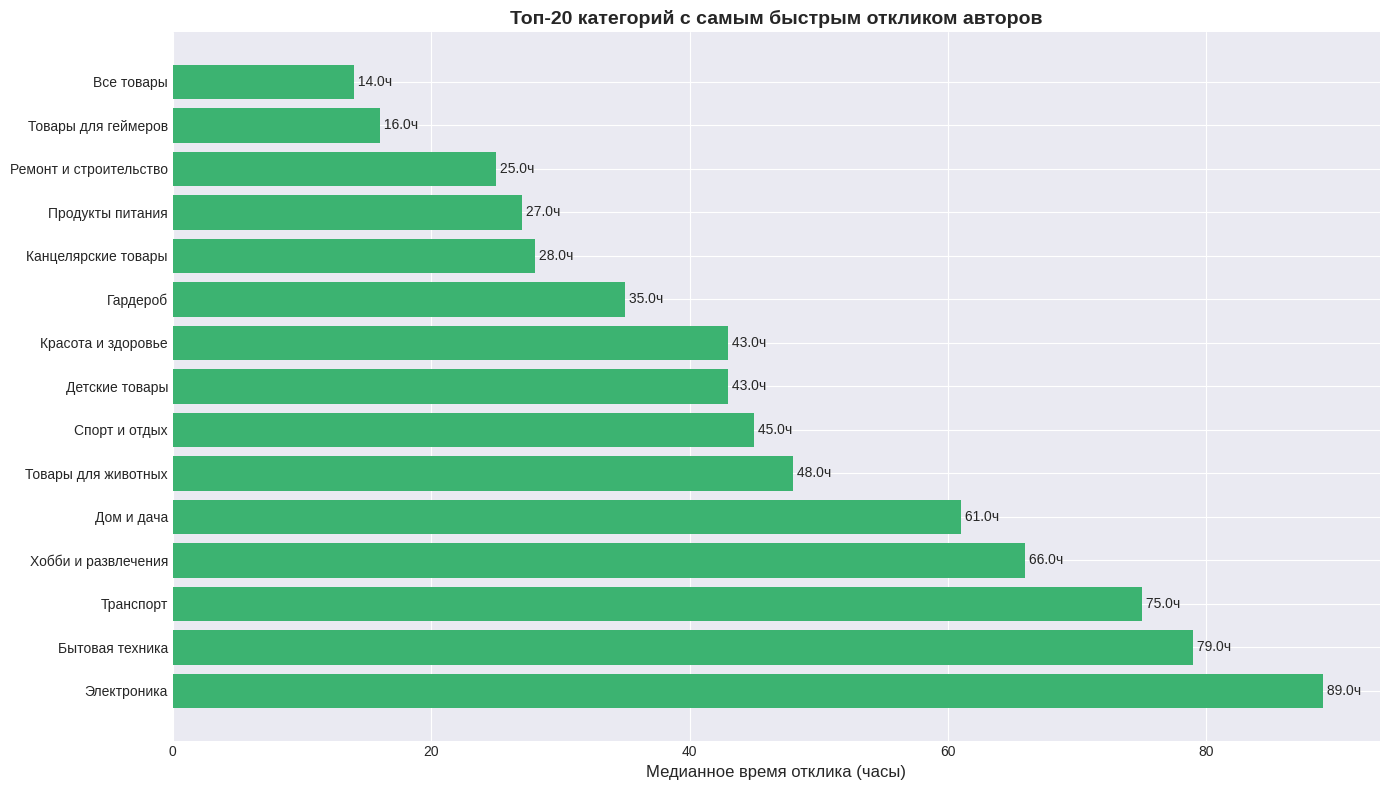

In [48]:
# 3.8. Скорость "разбора" оферов авторами
print("=" * 80)
print("ВОПРОС: Как быстро авторы берут в работу оферы из разных категорий?")
print("=" * 80)

# Вычисляем время от создания офера до создания размещения
master['time_to_placement'] = (master['placement_created_at'] - master['offer_created_at']).dt.total_seconds() / 3600  # в часах

category_speed = master.groupby('category').agg({
    'time_to_placement': ['mean', 'median', 'min', 'max'],
    'hash_placement_id': 'count'
}).round(2)

category_speed.columns = ['avg_hours', 'median_hours', 'min_hours', 'max_hours', 'placements']
category_speed = category_speed.sort_values('median_hours')

print(f"\n📊 Топ-15 категорий с самым быстрым откликом авторов:\n")
print(category_speed.head(15).to_string())
print()

print(f"\n📊 Топ-15 категорий с самым медленным откликом авторов:\n")
print(category_speed.tail(15).to_string())
print()

# Визуализация
plt.figure(figsize=(14, 8))
top_20_speed = category_speed.head(20)
plt.barh(range(len(top_20_speed)), top_20_speed['median_hours'], color='mediumseagreen')
plt.yticks(range(len(top_20_speed)), top_20_speed.index)
plt.xlabel('Медианное время отклика (часы)', fontsize=12)
plt.title('Топ-20 категорий с самым быстрым откликом авторов', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(top_20_speed['median_hours']):
    plt.text(v, i, f' {v:.1f}ч', va='center')
plt.tight_layout()
plt.show()

## 4. Блок 2: Механизмы взаимодействия селлера и авторов

ВОПРОС: Влияет ли размер вознаграждения на количество авторов, берущих офер?

📊 Корреляция между средним вознаграждением и количеством авторов:
   Коэффициент корреляции: 0.0554
   Интерпретация: Слабая связь


📊 Влияние уровня вознаграждения на активность:

                unique_authors  placements  completed_orders  avg_reward_per_order
reward_segment                                                                    
Очень низкое              4.52        4.56              7.02                411.79
Низкое                    5.04        5.08              5.96                827.27
Среднее                   5.43        5.49              6.03               1505.00
Высокое                   6.57        6.61              3.63               2601.87
Очень высокое             7.36        7.40              3.45               6692.96



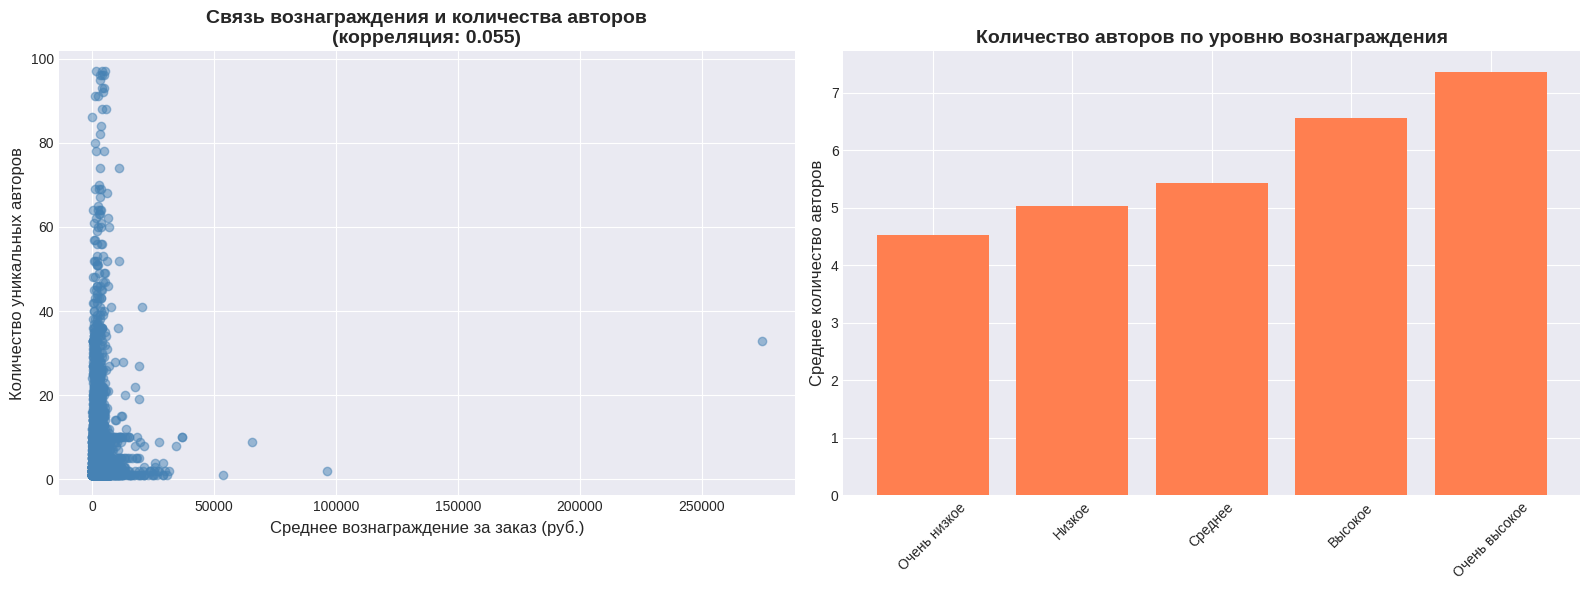

In [49]:
# 4.1. Корреляция между вознаграждением и количеством авторов
print("=" * 80)
print("ВОПРОС: Влияет ли размер вознаграждения на количество авторов, берущих офер?")
print("=" * 80)

# Вычисляем среднее вознаграждение на уровне офера
# Для этого нужно связать оферы с заказами через размещения
offers_with_rewards = master_published.groupby('hash_offer_id').agg({
    'total_reward': 'sum',
    'completed_orders': 'sum',
    'hash_author_id': 'nunique',
    'hash_placement_id': 'count',
    'category': 'first',
    'price': 'first'
}).rename(columns={
    'hash_author_id': 'unique_authors',
    'hash_placement_id': 'placements'
})

offers_with_rewards['avg_reward_per_order'] = (
    offers_with_rewards['total_reward'] / offers_with_rewards['completed_orders']
).fillna(0)

# Убираем оферы без заказов
offers_with_orders = offers_with_rewards[offers_with_rewards['completed_orders'] > 0].copy()

# Вычисляем корреляцию
correlation = offers_with_orders[['avg_reward_per_order', 'unique_authors']].corr().iloc[0, 1]

print(f"\n📊 Корреляция между средним вознаграждением и количеством авторов:")
print(f"   Коэффициент корреляции: {correlation:.4f}")
if abs(correlation) < 0.3:
    print(f"   Интерпретация: Слабая связь")
elif abs(correlation) < 0.7:
    print(f"   Интерпретация: Умеренная связь")
else:
    print(f"   Интерпретация: Сильная связь")
print()

# Сегментируем по размеру вознаграждения
offers_with_orders['reward_segment'] = pd.qcut(
    offers_with_orders['avg_reward_per_order'],
    q=5,
    labels=['Очень низкое', 'Низкое', 'Среднее', 'Высокое', 'Очень высокое'],
    duplicates='drop'
)

reward_impact = offers_with_orders.groupby('reward_segment').agg({
    'unique_authors': 'mean',
    'placements': 'mean',
    'completed_orders': 'mean',
    'avg_reward_per_order': 'mean'
}).round(2)

print(f"\n📊 Влияние уровня вознаграждения на активность:\n")
print(reward_impact.to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(offers_with_orders['avg_reward_per_order'], offers_with_orders['unique_authors'], alpha=0.5, color='steelblue')
axes[0].set_xlabel('Среднее вознаграждение за заказ (руб.)', fontsize=12)
axes[0].set_ylabel('Количество уникальных авторов', fontsize=12)
axes[0].set_title(f'Связь вознаграждения и количества авторов\n(корреляция: {correlation:.3f})', fontsize=14, fontweight='bold')

# Bar chart по сегментам
if 'reward_segment' in offers_with_orders.columns:
    axes[1].bar(range(len(reward_impact)), reward_impact['unique_authors'], color='coral')
    axes[1].set_xticks(range(len(reward_impact)))
    axes[1].set_xticklabels(reward_impact.index, rotation=45)
    axes[1].set_ylabel('Среднее количество авторов', fontsize=12)
    axes[1].set_title('Количество авторов по уровню вознаграждения', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [50]:
# 4.2. Самые эффективные авторы
print("=" * 80)
print("ВОПРОС: Какие авторы наиболее эффективны?")
print("=" * 80)

# Анализ по авторам
author_performance = master_published.groupby('hash_author_id').agg({
    'total_gmv': 'sum',
    'completed_orders': 'sum',
    'views': 'sum',
    'clicks': 'sum',
    'total_reward': 'sum',
    'hash_placement_id': 'count',
    'category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown',  # самая частая категория
}).rename(columns={'hash_placement_id': 'placements'})

author_performance['avg_gmv_per_placement'] = author_performance['total_gmv'] / author_performance['placements']
author_performance['avg_reward_per_placement'] = author_performance['total_reward'] / author_performance['placements']
author_performance['CTR'] = (author_performance['clicks'] / author_performance['views'] * 100).fillna(0)

# Исправленная формула для CR, чтобы избежать Inf
author_performance['CR'] = np.where(
    author_performance['clicks'] == 0,
    0, # Если кликов 0, ставим CR 0, чтобы избежать Inf
    (author_performance['completed_orders'] / author_performance['clicks'] * 100)
)

# Топ авторов по GMV
print(f"\n📊 Топ-10 авторов по GMV:\n")
top_authors_gmv = author_performance.sort_values('total_gmv', ascending=False).head(10)
print(top_authors_gmv[['total_gmv', 'completed_orders', 'placements', 'avg_reward_per_placement', 'CTR', 'CR']].to_string())
print()

# Топ авторов по конверсии
print(f"\n📊 Топ-10 авторов по CR (минимум 100 просмотров):\n")
top_authors_cr = author_performance[author_performance['views'] >= 100].sort_values('CR', ascending=False).head(10)
print(top_authors_cr[['CR', 'CTR', 'total_gmv', 'completed_orders', 'placements']].to_string())
print()

# Средний заработок автора
print(f"\n📊 Статистика заработка авторов:")
print(f"   Средний заработок на автора: {author_performance['total_reward'].mean():,.2f} руб.")
print(f"   Медианный заработок: {author_performance['total_reward'].median():,.2f} руб.")
print(f"   Средний заработок с одного размещения: {author_performance['avg_reward_per_placement'].mean():,.2f} руб.")
print()

ВОПРОС: Какие авторы наиболее эффективны?

📊 Топ-10 авторов по GMV:

                                                                  total_gmv  completed_orders  placements  avg_reward_per_placement       CTR         CR
hash_author_id                                                                                                                                          
E2628662818F57A41C342653AB5ABACBA7BE97C3DACF6AF99A6A0799212902ED  8781871.0             668.0          60              38668.533333  0.024197   2.482902
A89BD32E72E6A4FBDFAD76A87C9EF3D1F9890EFE80DE7F7295CF69B2E6CB7BFE  5549000.0            1248.0          50              47573.460000  0.018371  67.313916
9173CA4982B52803F4AB61D20462F3EF7E8C1AD493A384FB1E7065BEA1A8631E  2479018.0             358.0          15              44225.000000  0.692929   2.472205
2315BD64E75A346541681575E5B227059BC726907F5A5B893505B648A3062E77  2281330.0             285.0          25              36422.440000  0.318712   2.164502
83CF8B609DE60

ВОПРОС: Какой процент заказов отменяется?

📊 Распределение статусов заказов:

   Завершен: 22,816 (81.06%)
   Отменен: 5,284 (18.77%)
   В доставке: 35 (0.12%)
   Создан: 11 (0.04%)


📊 Топ-15 категорий с самым высоким процентом отмен:

                        total_orders  cancelled_orders  cancellation_rate
category                                                                 
Гардероб                        4623              1792          38.762708
Спорт и отдых                   1941               568          29.263266
Электроника                      474               138          29.113924
Бытовая техника                 1074               236          21.973929
Канцелярские товары              450                73          16.222222
Детские товары                   568                88          15.492958
Ремонт и строительство           141                21          14.893617
Транспорт                        445                66          14.831461
Все товары             

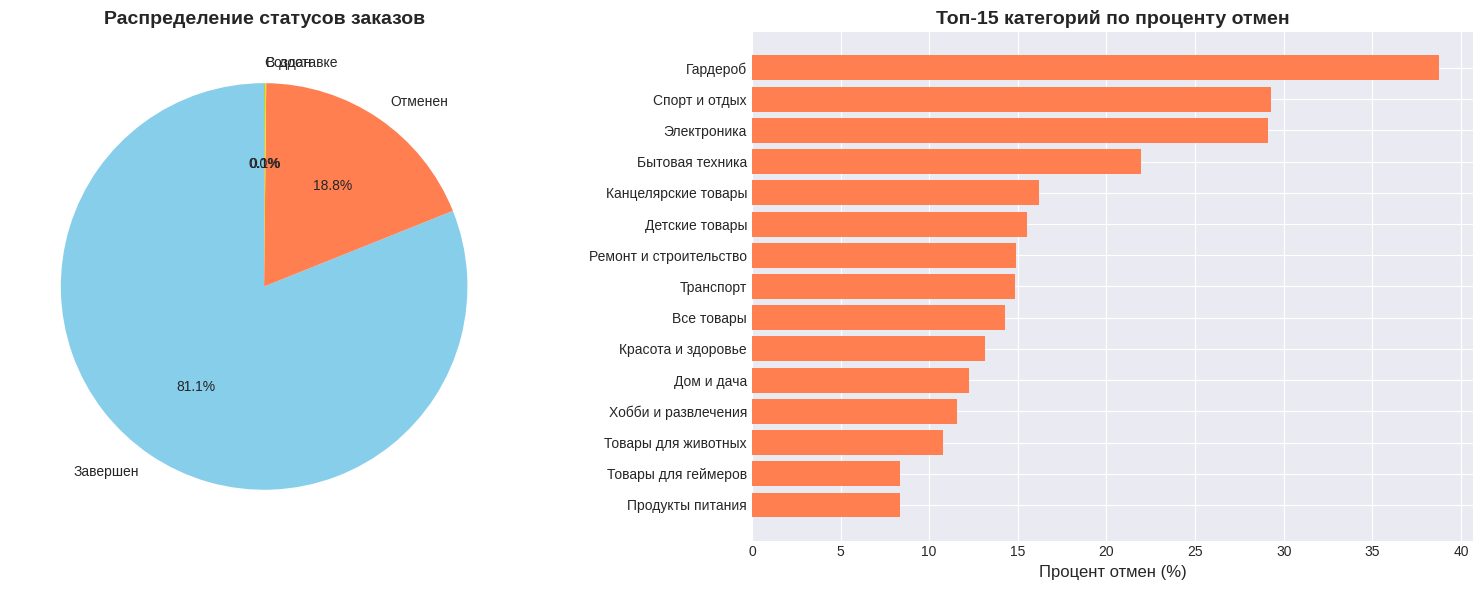

In [51]:
# 4.3. Процент отмененных заказов
print("=" * 80)
print("ВОПРОС: Какой процент заказов отменяется?")
print("=" * 80)

# Анализ статусов заказов
order_statuses = df_orders_test['order_status_code'].value_counts()
status_names = {'2': 'Создан', '3': 'Отменен', '4': 'В доставке', '5': 'Завершен'}

print(f"\n📊 Распределение статусов заказов:\n")
for status, count in order_statuses.items():
    pct = count / len(df_orders_test) * 100
    status_name = status_names.get(str(status), f'Неизвестен ({status})') # Convert status to string for lookup
    print(f"   {status_name}: {count:,} ({pct:.2f}%)")
print()

# Процент отмен по категориям
orders_with_category = df_orders_test.merge(
    master[['hash_placement_id', 'category']].drop_duplicates(),
    on='hash_placement_id',
    how='left'
)

category_cancellation = orders_with_category.groupby('category').agg({
    'hash_order_id': 'count',
    'order_status_code': lambda x: (x == '3').sum() # Changed 3 to '3'
}).rename(columns={
    'hash_order_id': 'total_orders',
    'order_status_code': 'cancelled_orders'
})

category_cancellation['cancellation_rate'] = (
    category_cancellation['cancelled_orders'] / category_cancellation['total_orders'] * 100
).fillna(0)

category_cancellation_sorted = category_cancellation.sort_values('cancellation_rate', ascending=False)

print(f"\n📊 Топ-15 категорий с самым высоким процентом отмен:\n")
print(category_cancellation_sorted.head(15).to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart статусов
axes[0].pie(order_statuses.values, labels=[status_names.get(str(s), s) for s in order_statuses.index], # Convert status to string for lookup
            autopct='%1.1f%%', startangle=90, colors=['skyblue', 'coral', 'gold', 'mediumseagreen'])
axes[0].set_title('Распределение статусов заказов', fontsize=14, fontweight='bold')

# Bar chart отмен по категориям
top_15_cancel = category_cancellation_sorted.head(15)
axes[1].barh(range(len(top_15_cancel)), top_15_cancel['cancellation_rate'], color='coral')
axes[1].set_yticks(range(len(top_15_cancel)))
axes[1].set_yticklabels(top_15_cancel.index)
axes[1].set_xlabel('Процент отмен (%)', fontsize=12)
axes[1].set_title('Топ-15 категорий по проценту отмен', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [70]:
# 4.4. Характеристики "виральных" оферов
print("=" * 80)
print("ВОПРОС: Какие характеристики офера приводят к наибольшему вовлечению?")
print("=" * 80)

# Анализ характеристик с высоким вовлечением
viral_analysis = master_published.groupby(['category', format_col, 'price_segment']).agg({
    'views': 'mean',
    'clicks': 'mean',
    'completed_orders': 'mean',
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'count'})

viral_analysis['CTR'] = (viral_analysis['clicks'] / viral_analysis['views'] * 100).fillna(0)

# Фильтруем комбинации с достаточной выборкой
viral_analysis_filtered = viral_analysis[viral_analysis['count'] >= 5].copy()
viral_analysis_sorted = viral_analysis_filtered.sort_values('CTR', ascending=False)

print(f"\n📊 Топ-20 комбинаций характеристик с высоким CTR:\n")
print(viral_analysis_sorted[['views', 'clicks', 'CTR', 'completed_orders', 'count']].head(20).to_string())
print()

# Анализ специализации авторов
author_categories = master.groupby('hash_author_id')['category'].agg(lambda x: x.mode()[0] if len(x) > 0 and not x.mode().empty else 'None')
author_placements = master.groupby('hash_author_id').size()

specialized_authors = (author_categories.notna()).sum()
total_authors = len(author_categories)

print(f"\n📊 Специализация авторов:")
print(f"   Всего авторов: {total_authors}")
print(f"   Авторов со специализацией: {specialized_authors}")
print()

# Авторы, работающие с одной категорией
author_category_count = master.groupby('hash_author_id')['category'].nunique()
single_category_authors = (author_category_count == 1).sum()

print(f"   Авторов, работающих только с одной категорией: {single_category_authors} ({single_category_authors/total_authors*100:.1f}%)")
print()

ВОПРОС: Какие характеристики офера приводят к наибольшему вовлечению?

📊 Топ-20 комбинаций характеристик с высоким CTR:

                                                                     views     clicks       CTR  completed_orders  count
category            placement_format_placement price_segment                                                            
Канцелярские товары post                       2000-5000      23528.760000  78.660000  0.334314          1.280000     50
Хобби и развлечения post                       500-1000       14620.967742  29.677419  0.202978          4.322581     31
Электроника         post                       10000-50000    45950.524823  70.035461  0.152415          0.106383    141
Бытовая техника     post                       >50000         27457.180556  38.819444  0.141382          0.097222     72
Канцелярские товары post                       10000-50000    29265.559524  40.654762  0.138917          0.345238     84
Транспорт           post        

ВОПРОС: Сколько времени проходит от публикации до первого заказа?

📊 Общая статистика времени до первого заказа:
   Среднее: 102.52 часов
   Медиана: 47.00 часов
   Минимум: 0.00 часов
   Максимум: 709.00 часов


📊 Топ-15 категорий с самым быстрым первым заказом (импульсивные покупки):

                              mean  median  count
category                                         
Транспорт               116.112299    40.0    187
Красота и здоровье       96.185239    41.0   1382
Дом и дача              101.828418    43.0   2238
Бытовая техника         106.431624    44.0    468
Продукты питания        106.052459    44.0    305
Электроника             105.106481    46.5    216
Спорт и отдых            91.354620    47.5    736
Ремонт и строительство   86.382716    48.0     81
Товары для животных     101.902256    48.0    133
Хобби и развлечения     108.780000    51.5    300
Гардероб                106.580805    52.0   1615
Детские товары          110.026119    59.0    268
Канцелярские

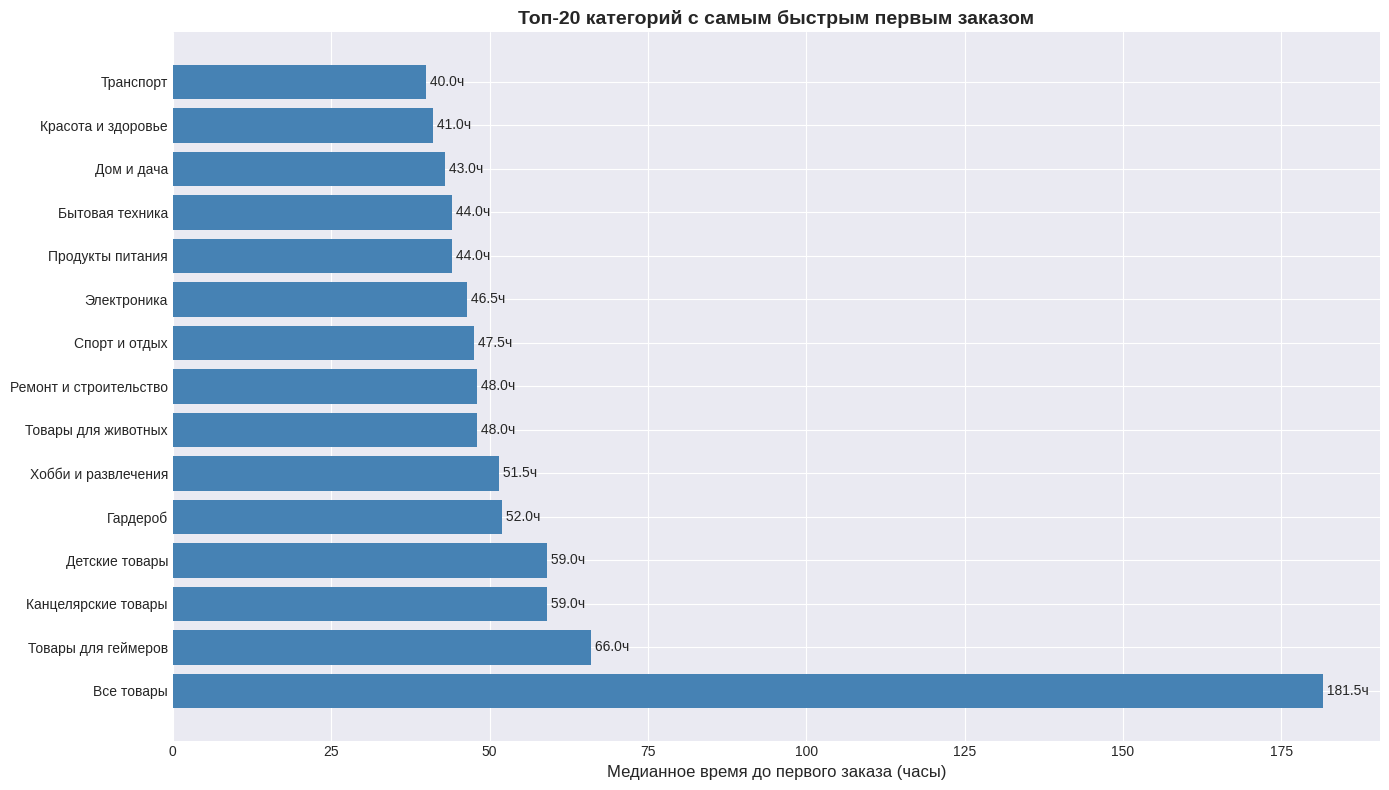

In [53]:
# 4.5. Время от публикации до первого заказа
print("=" * 80)
print("ВОПРОС: Сколько времени проходит от публикации до первого заказа?")
print("=" * 80)

# Находим первый заказ для каждого размещения
first_orders = df_orders_test.sort_values('order_created_at').groupby('hash_placement_id').first().reset_index()

# Объединяем с данными о размещениях
fmt_col = 'placement_format' if 'placement_format' in master.columns else 'placement_format_placement'
first_orders_with_placements = first_orders.merge(
    master[['hash_placement_id', 'published_at', 'category', fmt_col]].drop_duplicates(),
    on='hash_placement_id',
    how='left'
)

# Вычисляем время до первого заказа
first_orders_with_placements['time_to_first_order'] = (
    first_orders_with_placements['order_created_at'] - first_orders_with_placements['published_at']
).dt.total_seconds() / 3600  # в часах

# Убираем отрицательные значения (ошибки данных)
first_orders_clean = first_orders_with_placements[first_orders_with_placements['time_to_first_order'] >= 0].copy()

print(f"\n📊 Общая статистика времени до первого заказа:")
print(f"   Среднее: {first_orders_clean['time_to_first_order'].mean():.2f} часов")
print(f"   Медиана: {first_orders_clean['time_to_first_order'].median():.2f} часов")
print(f"   Минимум: {first_orders_clean['time_to_first_order'].min():.2f} часов")
print(f"   Максимум: {first_orders_clean['time_to_first_order'].max():.2f} часов")
print()

# По категориям
time_by_category = first_orders_clean.groupby('category')['time_to_first_order'].agg(['mean', 'median', 'count'])
time_by_category_sorted = time_by_category.sort_values('median')

print(f"\n📊 Топ-15 категорий с самым быстрым первым заказом (импульсивные покупки):\n")
print(time_by_category_sorted.head(15).to_string())
print()

print(f"\n📊 Топ-15 категорий с самым медленным первым заказом:\n")
print(time_by_category_sorted.tail(15).to_string())
print()

# Визуализация
plt.figure(figsize=(14, 8))
top_20_fast = time_by_category_sorted.head(20)
plt.barh(range(len(top_20_fast)), top_20_fast['median'], color='steelblue')
plt.yticks(range(len(top_20_fast)), top_20_fast.index)
plt.xlabel('Медианное время до первого заказа (часы)', fontsize=12)
plt.title('Топ-20 категорий с самым быстрым первым заказом', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(top_20_fast['median']):
    plt.text(v, i, f' {v:.1f}ч', va='center')
plt.tight_layout()
plt.show()

In [54]:
# Проверка уникальных значений и их количества в 'placement_format_placement'
print("Уникальные значения и их количество в master_published['placement_format_placement']:")
print(master_published['placement_format_placement'].value_counts(dropna=False))

Уникальные значения и их количество в master_published['placement_format_placement']:
placement_format_placement
clip    75017
post    12373
Name: count, dtype: int64


## 5. Блок 3: Невовлеченные товары и селлеры

ВОПРОС: Какие категории имеют много оферов, но мало размещений?

📊 Топ-15 категорий с низкой конверсией офер→размещение (авторы игнорируют):

                        offers_count  placements_count  placement_rate  placements_per_offer
category                                                                                    
Все товары                        73               129      176.712329              1.767123
Хобби и развлечения             1416              3185      224.929379              2.249294
Товары для геймеров               37                93      251.351351              2.513514
Ремонт и строительство           500              1304      260.800000              2.608000
Гардероб                        7895             21898      277.365421              2.773654
Спорт и отдых                   3986             11283      283.065730              2.830657
Красота и здоровье              3626             10334      284.997242              2.849972
Товары для животных  

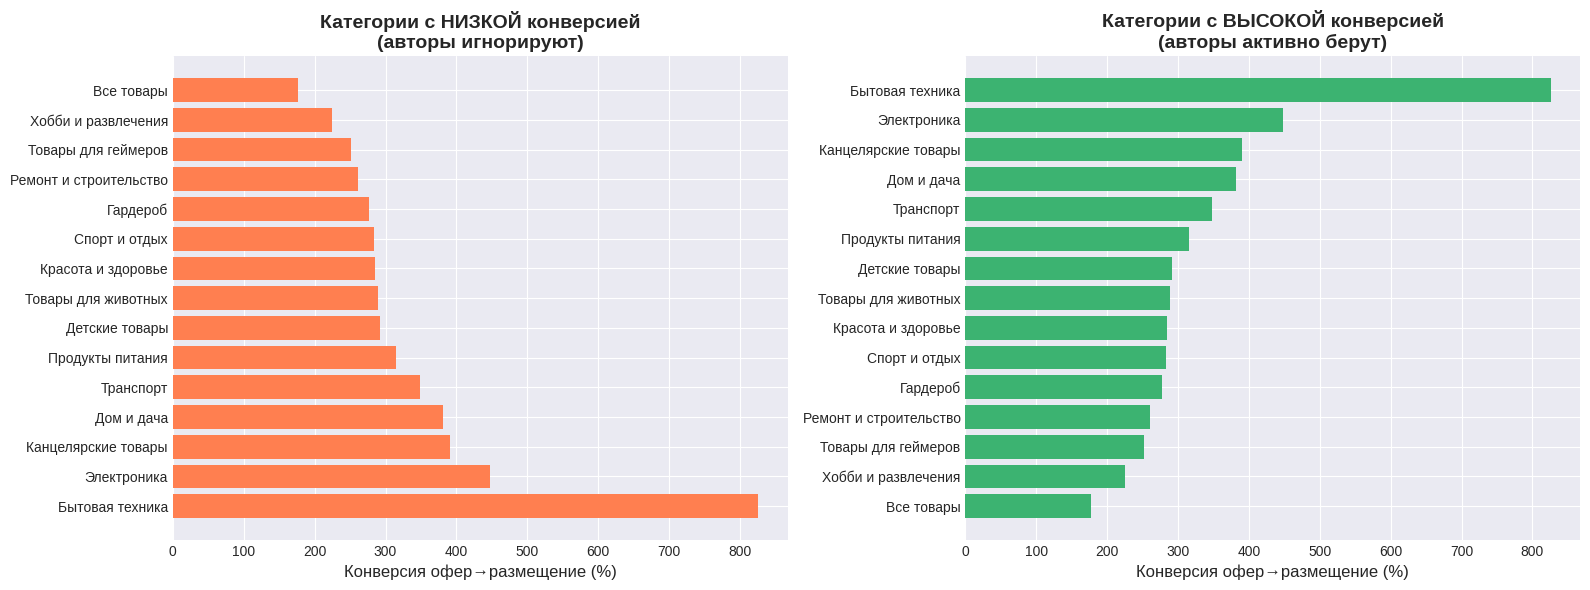

In [55]:
# 5.1. Категории с низкой конверсией оферов в размещения
print("=" * 80)
print("ВОПРОС: Какие категории имеют много оферов, но мало размещений?")
print("=" * 80)

# Подсчитываем офферы и размещения по категориям
offers_per_category = df_offers.groupby('category').agg({
    'hash_offer_id': 'nunique'
}).rename(columns={'hash_offer_id': 'offers_count'})

placements_per_category = master.groupby('category').agg({
    'hash_placement_id': 'count'
}).rename(columns={'hash_placement_id': 'placements_count'})

offer_to_placement = offers_per_category.join(placements_per_category, how='left').fillna(0)
offer_to_placement['placement_rate'] = (offer_to_placement['placements_count'] / offer_to_placement['offers_count'] * 100)
offer_to_placement['placements_per_offer'] = offer_to_placement['placements_count'] / offer_to_placement['offers_count']

offer_to_placement_sorted = offer_to_placement.sort_values('placement_rate')

print(f"\n📊 Топ-15 категорий с низкой конверсией офер→размещение (авторы игнорируют):\n")
low_engagement = offer_to_placement_sorted[offer_to_placement_sorted['offers_count'] >= 10].head(15)
print(low_engagement.to_string())
print()

print(f"\n📊 Категории с хорошей конверсией офер→размещение:\n")
high_engagement = offer_to_placement.sort_values('placement_rate', ascending=False).head(15)
print(high_engagement.to_string())
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Низкая конверсия
axes[0].barh(range(len(low_engagement)), low_engagement['placement_rate'], color='coral')
axes[0].set_yticks(range(len(low_engagement)))
axes[0].set_yticklabels(low_engagement.index)
axes[0].set_xlabel('Конверсия офер→размещение (%)', fontsize=12)
axes[0].set_title('Категории с НИЗКОЙ конверсией\n(авторы игнорируют)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Высокая конверсия
axes[1].barh(range(len(high_engagement)), high_engagement['placement_rate'], color='mediumseagreen')
axes[1].set_yticks(range(len(high_engagement)))
axes[1].set_yticklabels(high_engagement.index)
axes[1].set_xlabel('Конверсия офер→размещение (%)', fontsize=12)
axes[1].set_title('Категории с ВЫСОКОЙ конверсией\n(авторы активно берут)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [56]:
# 5.2. Категории с высокими просмотрами, но низким CTR
print("=" * 80)
print("ВОПРОС: Какие категории/товары имеют высокие просмотры, но низкий CTR?")
print("=" * 80)

# Фильтруем категории с достаточным количеством просмотров
category_ctr_analysis = category_metrics[category_metrics['views'] >= 1000].copy()
category_ctr_analysis_sorted = category_ctr_analysis.sort_values('CTR')

print(f"\n📊 Топ-15 категорий с высокими просмотрами, но низким CTR:\n")
low_ctr = category_ctr_analysis_sorted.head(15)
print(low_ctr[['views', 'clicks', 'CTR', 'completed_orders', 'placements']].to_string())
print()

print(f"\n💡 Интерпретация:")
print(f"   Эти категории генерируют интерес (просмотры), но товары не привлекательны")
print(f"   Возможные причины: цена, качество контента, описание товара")
print()

ВОПРОС: Какие категории/товары имеют высокие просмотры, но низкий CTR?

📊 Топ-15 категорий с высокими просмотрами, но низким CTR:

                              views    clicks       CTR  completed_orders  placements
category                                                                             
Транспорт                90809896.0   14895.0  0.016402             445.0        2513
Все товары                3795695.0     688.0  0.018126              14.0         124
Продукты питания         78678188.0   17327.0  0.022023            1008.0        2146
Бытовая техника         222245391.0   49853.0  0.022432            1074.0        6278
Товары для животных      47816488.0   10883.0  0.022760             650.0        1160
Гардероб                733769082.0  169466.0  0.023095            4623.0       20708
Спорт и отдых           416164814.0   96349.0  0.023152            1941.0       10565
Товары для геймеров       2389449.0     579.0  0.024232              12.0          81
Красота и

In [57]:
# 5.3. Категории с хорошим CTR, но низким CR
print("=" * 80)
print("ВОПРОС: Какие категории/товары имеют хороший CTR, но низкий CR?")
print("=" * 80)

# Фильтруем категории с достаточным количеством кликов
category_cr_analysis = category_metrics[category_metrics['clicks'] >= 100].copy()

# Находим категории с высоким CTR, но низким CR
category_cr_analysis['ctr_cr_gap'] = category_cr_analysis['CTR'] - category_cr_analysis['CR_clicks']
category_cr_analysis_sorted = category_cr_analysis.sort_values('ctr_cr_gap', ascending=False)

print(f"\n📊 Топ-15 категорий с высоким CTR, но низким CR (большой разрыв):\n")
high_ctr_low_cr = category_cr_analysis_sorted.head(15)
print(high_ctr_low_cr[['CTR', 'CR_clicks', 'ctr_cr_gap', 'clicks', 'completed_orders', 'avg_check']].to_string())
print()

print(f"\n💡 Интерпретация:")
print(f"   Люди кликают, но не покупают")
print(f"   Возможные причины: завышенная цена, несоответствие ожиданиям,")
print(f"   проблема на странице товара маркетплейса")
print()

ВОПРОС: Какие категории/товары имеют хороший CTR, но низкий CR?

📊 Топ-15 категорий с высоким CTR, но низким CR (большой разрыв):

                             CTR  CR_clicks  ctr_cr_gap    clicks  completed_orders     avg_check
category                                                                                         
Ремонт и строительство  0.032018   1.041975   -1.009956   13532.0             141.0  14322.205674
Электроника             0.030424   1.059834   -1.029410   44724.0             474.0  13376.210970
Детские товары          0.027154   1.648527   -1.621373   34455.0             568.0   7310.528169
Спорт и отдых           0.023152   2.014551   -1.991400   96349.0            1941.0   9158.139104
Хобби и развлечения     0.050142   2.052932   -2.002790   40089.0             823.0   4705.941677
Все товары              0.018126   2.034884   -2.016758     688.0              14.0   7766.428571
Товары для геймеров     0.024232   2.072539   -2.048307     579.0              12.0  

In [58]:
# 5.4. Продавцы с низким вовлечением
print("=" * 80)
print("ВОПРОС: Есть ли продавцы, чьи оферы систематически игнорируются?")
print("=" * 80)

# Анализ по продавцам
seller_performance = df_offers.merge(
    master.groupby('hash_offer_id').agg({
        'hash_placement_id': 'count',
        'hash_author_id': 'nunique'
    }).rename(columns={'hash_placement_id': 'placements', 'hash_author_id': 'unique_authors'}),
    on='hash_offer_id',
    how='left'
).fillna(0)

seller_stats = seller_performance.groupby('hash_seller_id').agg({
    'hash_offer_id': 'count',
    'placements': 'sum',
    'unique_authors': 'sum',
    'category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Mixed'
}).rename(columns={'hash_offer_id': 'offers_count'})

seller_stats['placements_per_offer'] = seller_stats['placements'] / seller_stats['offers_count']
seller_stats['authors_per_offer'] = seller_stats['unique_authors'] / seller_stats['offers_count']

# Продавцы с низким откликом
seller_stats_sorted = seller_stats.sort_values('placements_per_offer')

print(f"\n📊 Топ-15 продавцов с низким откликом авторов:\n")
low_engagement_sellers = seller_stats_sorted[seller_stats_sorted['offers_count'] >= 5].head(15)
print(low_engagement_sellers.to_string())
print()

print(f"\n📊 Топ-15 продавцов с высоким откликом авторов:\n")
high_engagement_sellers = seller_stats.sort_values('placements_per_offer', ascending=False).head(15)
print(high_engagement_sellers.to_string())
print()

# Анализ процента отмен по продавцам
seller_orders = df_orders_test.merge(
    master[['hash_placement_id', 'hash_seller_id']].drop_duplicates(),
    on='hash_placement_id',
    how='left'
)

seller_cancellation = seller_orders.groupby('hash_seller_id').agg({
    'hash_order_id': 'count',
    'order_status_code': lambda x: (x == 3).sum()
}).rename(columns={
    'hash_order_id': 'total_orders',
    'order_status_code': 'cancelled_orders'
})

seller_cancellation['cancellation_rate'] = (
    seller_cancellation['cancelled_orders'] / seller_cancellation['total_orders'] * 100
)

seller_cancellation_sorted = seller_cancellation.sort_values('cancellation_rate', ascending=False)

print(f"\n📊 Топ-15 продавцов с высоким процентом отмен (минимум 10 заказов):\n")
high_cancel_sellers = seller_cancellation_sorted[seller_cancellation_sorted['total_orders'] >= 10].head(15)
print(high_cancel_sellers.to_string())
print()

ВОПРОС: Есть ли продавцы, чьи оферы систематически игнорируются?

📊 Топ-15 продавцов с низким откликом авторов:

Empty DataFrame
Columns: [offers_count, placements, unique_authors, category, placements_per_offer, authors_per_offer]
Index: []


📊 Топ-15 продавцов с высоким откликом авторов:

                                                                  offers_count  placements  unique_authors            category  placements_per_offer  authors_per_offer
hash_seller_id                                                                                                                                                         
DCB57707F6F00ED16DB4F25CC3B3ECCB2C4C444398FA262D6F5308A129174512             1         101             101          Дом и дача                 101.0              101.0
EC5AE8D172F7A893C96681CAE55B942CE57D8E9FC9A968B9201D469F896EA6B0             1         100             100     Бытовая техника                 100.0              100.0
3A6FE01402333CDF3412FC08782A0AC13ADE

ГИПОТЕЗА: Невовлеченные товары преимущественно дорогие?

📊 Сравнение цен популярных vs непопулярных категорий:
   Средняя цена в популярных категориях: 77,796.54 руб.
   Средняя цена в непопулярных категориях: 47,608.90 руб.
   Разница: -30,187.64 руб. (-38.8%)

✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Непопулярные категории дешевле на 38.8% 



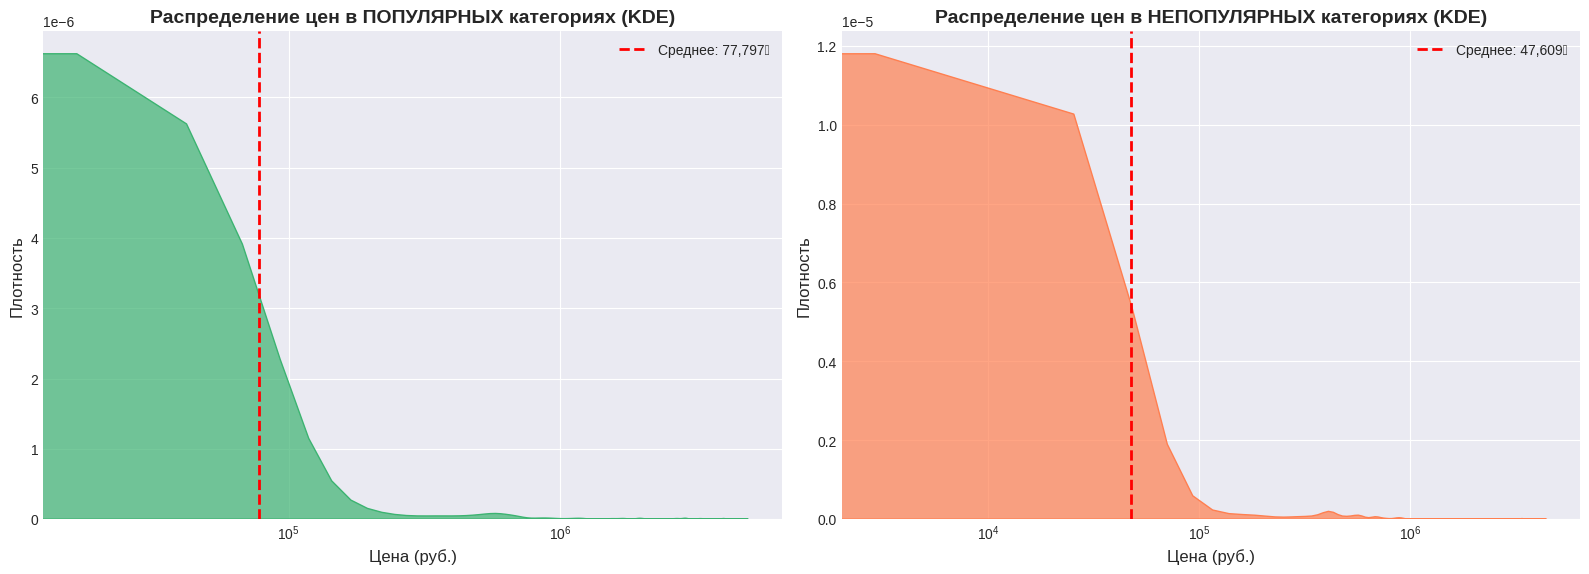

In [78]:
# 5.5. Гипотеза: Невовлеченные товары — это дорогие товары?
print("=" * 80)
print("ГИПОТЕЗА: Невовлеченные товары преимущественно дорогие?")
print("=" * 80)

# Сравниваем среднюю цену популярных и непопулярных категорий
popular_categories = offer_to_placement.sort_values('placement_rate', ascending=False).head(10).index
unpopular_categories = offer_to_placement[offer_to_placement['offers_count'] >= 10].sort_values('placement_rate').head(10).index

avg_price_popular = df_offers[df_offers['category'].isin(popular_categories)]['price'].mean()
avg_price_unpopular = df_offers[df_offers['category'].isin(unpopular_categories)]['price'].mean()

print(f"\n📊 Сравнение цен популярных vs непопулярных категорий:")
print(f"   Средняя цена в популярных категориях: {avg_price_popular:,.2f} руб.")
print(f"   Средняя цена в непопулярных категориях: {avg_price_unpopular:,.2f} руб.")
print(f"   Разница: {avg_price_unpopular - avg_price_popular:,.2f} руб. ({(avg_price_unpopular/avg_price_popular - 1)*100:+.1f}%)")
print()

if avg_price_unpopular > avg_price_popular * 1.2:
    print(f"✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Непопулярные категории дороже на {(avg_price_unpopular/avg_price_popular - 1)*100:.1f}%")
elif avg_price_unpopular < avg_price_popular * 0.8:
    print(f"✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Непопулярные категории дешевле на {-(avg_price_unpopular/avg_price_popular - 1)*100:.1f}% ")
else:
    print(f"✗ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА: Разница в цене незначительна")
print()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Распределение цен популярных категорий с KDE
prices_popular = df_offers[df_offers['category'].isin(popular_categories)]['price']
sns.kdeplot(prices_popular, ax=axes[0], fill=True, color='mediumseagreen', alpha=0.7)
axes[0].axvline(avg_price_popular, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_price_popular:,.0f}₽')
axes[0].set_xlabel('Цена (руб.)', fontsize=12)
axes[0].set_ylabel('Плотность', fontsize=12)
axes[0].set_title('Распределение цен в ПОПУЛЯРНЫХ категориях (KDE)', fontsize=14, fontweight='bold')
axes[0].set_xscale('log') # Устанавливаем логарифмическую шкалу
axes[0].legend()

# Распределение цен непопулярных категорий с KDE
prices_unpopular = df_offers[df_offers['category'].isin(unpopular_categories)]['price']
sns.kdeplot(prices_unpopular, ax=axes[1], fill=True, color='coral', alpha=0.7)
axes[1].axvline(avg_price_unpopular, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_price_unpopular:,.0f}₽')
axes[1].set_xlabel('Цена (руб.)', fontsize=12)
axes[1].set_ylabel('Плотность', fontsize=12)
axes[1].set_title('Распределение цен в НЕПОПУЛЯРНЫХ категориях (KDE)', fontsize=14, fontweight='bold')
axes[1].set_xscale('log') # Устанавливаем логарифмическую шкалу
axes[1].legend()

plt.tight_layout()
plt.show()

In [60]:
# 5.6. Гипотеза: Низкое вознаграждение в невовлеченных категориях?
print("=" * 80)
print("ГИПОТЕЗА: Невовлеченные товары предлагают более низкое вознаграждение?")
print("=" * 80)

# Вычисляем процент вознаграждения от GMV по категориям
category_reward_analysis = master_published.groupby('category').agg({
    'total_reward': 'sum',
    'total_gmv': 'sum',
    'completed_orders': 'sum'
})

category_reward_analysis['reward_percent'] = (
    category_reward_analysis['total_reward'] / category_reward_analysis['total_gmv'] * 100
).fillna(0)

category_reward_analysis['avg_reward'] = (
    category_reward_analysis['total_reward'] / category_reward_analysis['completed_orders']
).fillna(0)

# Сравниваем популярные и непопулярные категории
reward_popular = category_reward_analysis.loc[
    category_reward_analysis.index.isin(popular_categories)
]['reward_percent'].mean()

reward_unpopular = category_reward_analysis.loc[
    category_reward_analysis.index.isin(unpopular_categories)
]['reward_percent'].mean()

print(f"\n📊 Сравнение вознаграждений популярных vs непопулярных категорий:")
print(f"   Средний % вознаграждения в популярных: {reward_popular:.2f}%")
print(f"   Средний % вознаграждения в непопулярных: {reward_unpopular:.2f}%")
print(f"   Разница: {reward_unpopular - reward_popular:+.2f}%")
print()

if reward_unpopular < reward_popular * 0.8:
    print(f"✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Непопулярные категории предлагают меньше вознаграждения")
else:
    print(f"✗ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА: Разница в вознаграждении незначительна")
print()

# Детальный анализ
print(f"\n📊 Вознаграждение в популярных категориях:\n")
reward_in_popular = category_reward_analysis.loc[popular_categories].sort_values('reward_percent', ascending=False)
print(reward_in_popular[['reward_percent', 'avg_reward', 'completed_orders']].to_string())
print()

print(f"\n📊 Вознаграждение в непопулярных категориях:\n")
reward_in_unpopular = category_reward_analysis.loc[unpopular_categories].sort_values('reward_percent', ascending=False)
print(reward_in_unpopular[['reward_percent', 'avg_reward', 'completed_orders']].to_string())
print()

ГИПОТЕЗА: Невовлеченные товары предлагают более низкое вознаграждение?

📊 Сравнение вознаграждений популярных vs непопулярных категорий:
   Средний % вознаграждения в популярных: 28.13%
   Средний % вознаграждения в непопулярных: 29.19%
   Разница: +1.06%

✗ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА: Разница в вознаграждении незначительна


📊 Вознаграждение в популярных категориях:

                     reward_percent   avg_reward  completed_orders
category                                                          
Товары для животных       32.784580  1606.921538             650.0
Дом и дача                32.011554  1301.636085            9450.0
Канцелярские товары       29.173777  1773.368889             450.0
Спорт и отдых             28.451439  2605.622360            1941.0
Красота и здоровье        27.471718   924.359652            6206.0
Продукты питания          27.359768   859.654762            1008.0
Электроника               26.512525  3546.371308             474.0
Детские товары            26

## 6. Итоговая сводка и ключевые выводы

In [63]:
# 6.1. Сводная таблица по всем категориям
print("=" * 80)
print("ИТОГОВАЯ СВОДКА: Комплексная оценка всех категорий")
print("=" * 80)

# Создаем итоговую таблицу
summary = pd.DataFrame({
    'Категория': category_metrics.index,
    'GMV': category_gmv.loc[category_metrics.index, 'total_gmv'].values,
    'CTR': category_metrics['CTR'].values,
    'CR': category_metrics['CR_clicks'].values,
    'Средний_чек': category_metrics['avg_check'].values,
    'Размещений': category_popularity.loc[category_metrics.index, 'placements'].values,
    'Офер→Размещение': offer_to_placement.loc[category_metrics.index, 'placement_rate'].values
})

# Нормализуем метрики для расчета общего рейтинга (0-100)
try:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 100))
    use_sklearn = True
except ImportError:
    use_sklearn = False

metrics_to_scale = ['GMV', 'CTR', 'CR', 'Размещений', 'Офер→Размещение']
summary_scaled = summary.copy()
if use_sklearn:
    summary_scaled[metrics_to_scale] = scaler.fit_transform(summary[metrics_to_scale])
else:
    for m in metrics_to_scale:
        col = summary[m]
        min_v, max_v = col.min(), col.max()
        if max_v > min_v:
            summary_scaled[m] = (col - min_v) / (max_v - min_v) * 100
        else:
            summary_scaled[m] = 0

# Рассчитываем общий рейтинг (взвешенная сумма)
weights = {
    'GMV': 0.25,
    'CTR': 0.20,
    'CR': 0.25,
    'Размещений': 0.15,
    'Офер→Размещение': 0.15
}

summary['Общий_рейтинг'] = sum(summary_scaled[metric] * weight for metric, weight in weights.items())
summary_sorted = summary.sort_values('Общий_рейтинг', ascending=False)

print(f"\n📊 Топ-20 категорий по комплексной оценке:\n")
print(summary_sorted.head(20).to_string())
print()

print(f"\n📊 Низ-20 категорий (требуют внимания):\n")
print(summary_sorted.tail(20).to_string())
print()

# Сохраняем результаты
summary_sorted.to_csv('data/category_summary.csv', index=False)
print(f"\n✓ Итоговая таблица сохранена в 'data/category_summary.csv'")
print()

ИТОГОВАЯ СВОДКА: Комплексная оценка всех категорий

📊 Топ-20 категорий по комплексной оценке:

                 Категория         GMV       CTR        CR   Средний_чек  Размещений  Офер→Размещение  Общий_рейтинг
4               Дом и дача  38425067.0  0.027545  4.941564   4066.144656       21210       381.474820      64.563034
2                 Гардероб  46647537.0  0.023095  2.727981  10090.317326       21898       277.365421      54.126029
6       Красота и здоровье  20881752.0  0.026195  6.423234   3364.768289       10334       284.997242      51.510992
0          Бытовая техника  17230465.0  0.022432  2.154334  16043.263501        6615       825.842697      37.425810
7         Продукты питания   3167176.0  0.022023  5.817510   3142.039683        2429       315.045396      31.964002
11     Товары для животных   3185946.0  0.022760  5.972618   4901.455385        1252       289.145497      31.723569
13     Хобби и развлечения   3872990.0  0.050142  2.052932   4705.941677        3185  

In [80]:
# 6.2. Ключевые выводы и рекомендации
print("=" * 80)
print("КЛЮЧЕВЫЕ ВЫВОДЫ")
print("=" * 80)

print(f"""
🎯 БЛОК 1: СТРАТЕГИЯ НАПОЛНЕНИЯ КАТАЛОГА

1. ТОП-КАТЕГОРИИ с наибольшим контентным потенциалом:
   • По GMV: {category_gmv.head(3).index.tolist()}
   • По CR: {category_metrics.sort_values('CR_clicks', ascending=False).head(3).index.tolist()}
   • По CTR: {category_metrics.sort_values('CTR', ascending=False).head(3).index.tolist()}

2. ФОРМАТЫ КОНТЕНТА:
   • Посты vs Клипы - анализ показал различия по категориям
   • Рекомендация: использовать разные форматы для разных категорий

3. ЦЕНОВОЙ ДИАПАЗОН для импульсивных покупок:
   • Оптимальный сегмент: {price_analysis.sort_values('CR', ascending=False).head(1).index[0]}
   • Средняя цена в этом сегменте: {price_analysis.sort_values('CR', ascending=False).head(1)['avg_price'].values[0]:,.0f} руб.

4. СКОРОСТЬ РЕАКЦИИ авторов:
   • Самые быстрые категории: {category_speed.head(3).index.tolist()}
   • Медианное время отклика: {category_speed.head(1)['median_hours'].values[0]:.1f} часов

---

🤝 БЛОК 2: МЕХАНИЗМЫ ВЗАИМОДЕЙСТВИЯ

1. МОТИВАЦИЯ АВТОРОВ:
   • Корреляция вознаграждения и количества авторов: {correlation:.3f}
   • Средний заработок автора: {author_performance['total_reward'].mean():,.2f} руб. (если author_performance посчитан)

2. ЭФФЕКТИВНЫЕ АВТОРЫ:
   • Топ-авторы генерируют значительно больше GMV
   • Рекомендация: создать программу лояльности для топ-авторов

3. ОТМЕНЫ ЗАКАЗОВ:
   • Общий процент отмен: {(order_statuses.get('3', 0) / len(df_orders_test) * 100):.1f}%
   • Высокие отмены в категориях: {category_cancellation_sorted.head(3).index.tolist()}

4. ВРЕМЯ ДО ПЕРВОГО ЗАКАЗА:
   • Среднее: {first_orders_clean['time_to_first_order'].mean():.1f} часов
   • Категории с быстрым откликом покупателей: {time_by_category_sorted.head(3).index.tolist()}

---

❌ БЛОК 3: НЕВОВЛЕЧЕННЫЕ ТОВАРЫ

1. ПРОБЛЕМНЫЕ КАТЕГОРИИ (низкая конверсия офер→размещение):
   • {low_engagement.head(5).index.tolist()}
   • Авторы не хотят брать эти товары в работу

2. КАТЕГОРИИ С НИЗКИМ CTR (интерес есть, но товар не привлекает):
   • {low_ctr.head(5).index.tolist()}

3. КАТЕГОРИИ С НИЗКИМ CR (кликают, но не покупают):
   • {high_ctr_low_cr.head(5).index.tolist()}

4. ГИПОТЕЗЫ:
   • Цена: {'Подтверждена' if avg_price_unpopular > avg_price_popular * 1.2 else 'Не подтверждена'}
   • Вознаграждение: {'Подтверждена' if reward_unpopular < reward_popular * 0.8 else 'Не подтверждена'}

"""
)

print("=" * 80)

КЛЮЧЕВЫЕ ВЫВОДЫ

🎯 БЛОК 1: СТРАТЕГИЯ НАПОЛНЕНИЯ КАТАЛОГА

1. ТОП-КАТЕГОРИИ с наибольшим контентным потенциалом:
   • По GMV: ['Гардероб', 'Дом и дача', 'Красота и здоровье']
   • По CR: ['Красота и здоровье', 'Товары для животных', 'Продукты питания']
   • По CTR: ['Хобби и развлечения', 'Канцелярские товары', 'Ремонт и строительство']

2. ФОРМАТЫ КОНТЕНТА:
   • Посты vs Клипы - анализ показал различия по категориям
   • Рекомендация: использовать разные форматы для разных категорий

3. ЦЕНОВОЙ ДИАПАЗОН для импульсивных покупок:
   • Оптимальный сегмент: <500
   • Средняя цена в этом сегменте: 448 руб.

4. СКОРОСТЬ РЕАКЦИИ авторов:
   • Самые быстрые категории: ['Все товары', 'Товары для геймеров', 'Ремонт и строительство']
   • Медианное время отклика: 14.0 часов

---

🤝 БЛОК 2: МЕХАНИЗМЫ ВЗАИМОДЕЙСТВИЯ

1. МОТИВАЦИЯ АВТОРОВ:
   • Корреляция вознаграждения и количества авторов: 0.055
   • Средний заработок автора: 10,467.06 руб. (если author_performance посчитан)

2. ЭФФЕКТИВНЫЕ АВТОР